In [1]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
plt.style.use("default")

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [2]:
filePath = os.getcwd()
# filePath = "/Users/joshuamaldonado/Documents/GitHub/SLM/"
eosName = "sorted_Sly4.dat"
fileName = filePath + "/EOS_Data/" + eosName

eos_filepath = fileName
tidal = False

In [3]:
rk4_runtimes = []
rk2_runtimes = []
euler_runtimes = []
solve_ivp_runtimes = []


class TOVsolver:

    def __init__(self, eos_filepath=None, tidal=False, solver="RK4", solve_ivp_kwargs=None):
        r"""
        Class to calculate the Tolman-Oppenheimer-Volkoff equations,
        including options for the tidal deformability and moment of
        inertia using RK4. Also includes uncertainty quantification
        techniques through the highest posterior density interval (HPD
        or HDI) calculation. Able to accept one EOS from a single curve
        or draws from an EOS, such as from a Gaussian Process.

        Example:
            tov = TOVSolver(eos_filepath='path/to/eos', tidal=True, moment=True)

        Parameters:
            eos_filepath (str): The path to the EOS data table to be used.

            tidal (bool): Whether to calculate tidal deformability or not.
                Default is False.

            moment (bool): Whether to calculate moment of inertia or not.
                Default is False.

        Returns:
            None.
        """

        # assign class variables
        self.tidal = tidal
        self.solver = solver
        self.solve_ivp_kwargs = solve_ivp_kwargs
        self.tol = 1e-9

        # assign scaled variables
        self.eps0 = 1.285e3  # MeV fm-3
        self.pres0 = self.eps0
        self.mass0 = 2.837  # solar masses
        self.rad0 = 8.378  # km
        

        # load in the data (expects file with data headers for now)
        if eos_filepath is not None:

            file_name, eos_file_extension = os.path.splitext(eos_filepath)
            print(file_name)
            self.eos_name = (file_name.split("/"))[-1]

            # for data from compOSE
            if eos_file_extension == ".table":
                # extract from .table file
                self.eos_file = eos_filepath
                eos_data = np.loadtxt(eos_filepath)

                # check which column is which
                if eos_data.T[4][-1] < eos_data.T[3][-1]:
                    self.eps_array = eos_data.T[3] / self.eps0
                    self.pres_array = eos_data.T[4] / self.pres0
                else:
                    self.eps_array = eos_data.T[4] / self.eps0
                    self.pres_array = eos_data.T[3] / self.pres0

                self.nB_array = eos_data.T[1]

                if tidal is True:
                    dpdeps = np.gradient(self.pres_array, self.eps_array, edge_order=2)
                    self.cs2_array = dpdeps
                else:
                    self.cs2_array = np.zeros([len(self.pres_array)])

                # keep unscaled for use in density calculation
                self.pres_array_unscaled = eos_data.T[4]

            # For data generated by codes
            elif eos_file_extension == ".dat" or eos_file_extension == ".txt":

                # extract data and assign to arrays (assumes one sample/draw of EOS)
                self.eos_file = eos_filepath
                eos_data = np.loadtxt(eos_filepath)  # , skiprows=2)
                self.eps_array = eos_data.T[1] / self.eps0
                self.pres_array = eos_data.T[2] / self.pres0
                self.nB_array = eos_data.T[0]
                if len(eos_data[1]) > 3:
                    self.cs2_array = eos_data.T[3]
                else:
                    self.cs2_array = None

                # keep unscaled for use in density calculation
                self.pres_array_unscaled = eos_data.T[2]

            elif eos_file_extension == ".npz":

                self.eos_file = eos_filepath
                eos_data = np.load(eos_filepath)

                # assign to arrays based on header names
                self.eps_array = eos_data["edens"] / self.eps0
                self.pres_array = eos_data["pres"] / self.pres0
                self.nB_array = eos_data["density"]
                self.cs2_array = eos_data["cs2"]

            # print congrats
            print("Woo it worked!")

        else:
            raise ValueError("No file specified.")

        return None

    # include the RK4 handwritten solver
    def RK4(self, f, x0, t0, te, N):
        r"""
        A simple RK4 solver to avoid overhead of
        calculating with solve_ivp or any other
        adaptive step-size function.

        Example:
            tov.RK4(f=func, x0=1., t0=1., te=10., N=100)

        Parameters:
            f (func): A Python function for the ODE(s) to be solved.
                Able to solve N coupled ODEs.

            x0 (float): Guess for the function(s) to be solved.

            t0 (float): Initial point of the grid.

            te (float): End point of the grid.

            N (int): The number of steps to take in the range (te-t0).

        Returns:
            times (array): The grid of solution steps.

            solution (array): The solutions of each function
                at each point in the grid.
        """
        
        # print(f, x0, t0, te, N)
        # print(type(f), type(x0), type(t0), type(te), type(N))
        # print("")
        
        h = (te - t0) / N
        times = np.arange(t0, te + h, h)
        solution = []
        x = x0

        for t in times:
            solution.append(np.array(x).T)
            k1 = h * f(t, x)
            k2 = h * f(t + 0.5 * h, x + 0.5 * k1)
            k3 = h * f(t + 0.5 * h, x + 0.5 * k2)
            k4 = h * f(t + h, x + k3)
            x += (k1 + 2 * (k2 + k3) + k4) / 6

        solution = np.asarray(solution, dtype=np.float64).T

        return times, solution
    
    def RK2(self, f, x0, t0, te, N):
        r"""
        A simple RK2 solver to avoid overhead of
        calculating with solve_ivp or any other
        adaptive step-size function.
        This is a low-fidelity solver.

        Example:
            tov.RK2(f=func, x0=1., t0=1., te=10., N=100)

        Parameters:
            f (func): A Python function for the ODE(s) to be solved.
                Able to solve N coupled ODEs.

            x0 (float): Guess for the function(s) to be solved.

            t0 (float): Initial point of the grid.

            te (float): End point of the grid.

            N (int): The number of steps to take in the range (te-t0).

        Returns:
            times (array): The grid of solution steps.

            solution (array): The solutions of each function
                at each point in the grid.
        """
        
        h = (te - t0) / N
        times = np.arange(t0, te + h, h)
        solution = []
        x = x0

        for t in times:
            solution.append(np.array(x).T)
            k1 = h * f(t, x)
            k2 = h * f(t + 0.5 * h, x + 0.5 * k1)
            x += k2

        solution = np.asarray(solution, dtype=np.float64).T

        return times, solution
    
    def euler(self, f, x0, t0, te, N):
        r"""
        A simple forward euler solver to avoid overhead of
        calculating with solve_ivp or any other
        adaptive step-size function.
        This is a low fidelity solver!

        Example:
            tov.euler(f=func, x0=1., t0=1., te=10., N=100)

        Parameters:
            f (func): A Python function for the ODE(s) to be solved.
                Able to solve N coupled ODEs.

            x0 (float): Guess for the function(s) to be solved.

            t0 (float): Initial point of the grid.

            te (float): End point of the grid.

            N (int): The number of steps to take in the range (te-t0).

        Returns:
            times (array): The grid of solution steps.

            solution (array): The solutions of each function
                at each point in the grid.
        """
        
        h = (te - t0) / N
        times = np.arange(t0, te + h, h)
        solution = []
        x = x0

        for t in times:
            solution.append(np.array(x).T)
            x += h * f(t, x)
            
        solution = np.asarray(solution, dtype=np.float64).T

        return times, solution

    def tov_equations_scaled(self, x, y0):
        r"""
        The Tolman-Oppenheimer-Volkoff equations in scaled format, to be
        solved with the RK4 routine. If selected, the tidal deformability
        and moment of inertia will be included and solved
        simultaneously.

        Example:
            tov.tov_equations_scaled(x=0.2,
                y0=[m_init, p_init])

        Parameters:
            x (float): A point in the scaled radius grid.

            y0 (list): The list of initial guesses for each function
                solved.

        Returns:
            The solutions, in array format, of each function to be
                solved.
        """

        # unpack the initial conditions
        if self.tidal is True:
            pres, mass, y = y0
            cs2 = self.cs2_interp(pres)
        else:
            pres, mass = y0

        eps = self.eps_interp(pres)

        # must also receive monotonically increasing P(n) results
        if pres > 0.0:

            # pressure equation
            dpdx = (
                -0.5 * (pres + eps) * (mass + 3 * x**3.0 * pres) / (x**2.0 - x * mass)
            )

            # mass equation
            dmdx = 3.0 * x**2.0 * eps

            # tidal deformability equation
            if self.tidal is True:
                f = self.f_x(x, mass, pres, eps)
                q = self.q_x(x, mass, pres, eps, cs2)
                dydx = -(1.0 / x) * (y**2.0 + f * y + q)

        else:
            dpdx = 0.0
            dmdx = 0.0

            if self.tidal is True:
                dydx = 0.0

        if self.tidal is True:
            return np.array([dpdx, dmdx, dydx], dtype=np.float64)

        return np.array([dpdx, dmdx], dtype=np.float64)

    def f_x(self, x, mass, pres, eps):
        r"""
        A function in the tidal deformability calculation.

        Example:
            tov.f_x(x=0.2, mass=1.06, pres=2.34, eps=6.0)

        Parameters:
            x (float): The current gridpoint in scaled radius.

            mass (float): The current mass.

            pres (float): The current pressure from the EOS.

            eps (float): The current energy density from the EOS.

        Returns:
            The value of F(x) at the current radius.
        """

        one = 1.0 - (3.0 / 2.0) * (eps - pres)
        two = 1.0 - mass / x
        return one / two

    def q_x(self, x, mass, pres, eps, cs2):
        r"""
        A function in the calculation of the tidal deformability.

        Example:
            tov.q_x(x=0.1, mass=2.0, pres=1.0, eps=3.0, cs2=0.33)

        Parameters:
            x (float): The current gridpoint in scaled radius.

            mass (float): The current mass.

            pres (float): The current pressure from the EOS.

            eps (float): The current energy density from the EOS.

            cs2 (float): The current speed of sound from the EOS.

        Returns:
            The value of Q(x) at the current radius.
        """
        pre = (3.0 / 2.0) * x**2.0 / (1.0 - mass / x)
        one = 5.0 * eps + 9.0 * pres + ((eps + pres) / cs2) - (4.0 / x**2.0)
        two = (mass / x) + 3.0 * x**2.0 * pres
        three = 1.0 - mass / x
        return pre * one - (two / three) ** 2.0

    # love number equations and tidal deformability
    def tidal_def(self, yR, mass, radius):
        r"""
        The calculation of the tidal deformability, Lambda, and
        the tidal Love number, k2. This function is calculated after
        the RK4 routine has been completed.

        Example:
            tov.tidal_def(yR=np.array, mass=np.array, radius=np.array)

        Parameters:
            yR (float): The array of y at the maximum radii points.

            mass (float): The array of mass at the maximum radii.

            radius (float): The maximum radii array.

        Returns:
            tidal_deform (array): The tidal deformability solved at
                each point in the maximum radius.

            k2 (array): The value of the Love number calculated at the
                compactness M/R and the value of y at maximum radius.
        """

        # love number calculation
        beta = mass / radius
        k2 = (
            (8.0 / 5.0)
            * beta**5.0
            * (1.0 - 2.0 * beta) ** 2.0
            * (2.0 - yR + 2.0 * beta * (yR - 1.0))
            * (
                2.0 * beta * (6.0 - 3.0 * yR + 3.0 * beta * (5.0 * yR - 8.0))
                + 4.0
                * beta**3.0
                * (
                    13.0
                    - 11.0 * yR
                    + beta * (3.0 * yR - 2.0)
                    + 2.0 * beta**2.0 * (1.0 + yR)
                )
                + 3.0
                * (1.0 - 2.0 * beta) ** 2.0
                * (2.0 - yR + 2.0 * beta * (yR - 1.0))
                * np.log(1.0 - 2.0 * beta)
            )
            ** (-1.0)
        )

        # tidal deformability calculation
        tidal_deform = (2.0 / 3.0) * k2 / (beta**5.0)

        return tidal_deform, k2

    def tov_routine(self, verbose=False, write_to_file=False):
        r"""
        The TOV routine to solve each set of coupled ODEs and to output
        the quantities needed to display the M-R curve, as well as the
        tidal deformability and moment of inertia if desired.

        Example:
            tov.tov_routine(verbose=True, write_to_file=True)

        Parameters:
            verbose (bool): Whether to plot quantities and display
                the full maximum mass array. Default is False.

            write_to_file (bool): Choice to write the TOV results to
                a file located in a folder of the user's choice.
                Default is False.

        Returns:
            self.total_radius (array): The array of total maximum
                radius values.

            self.total_pres_central (array): The array of total
                central pressure values.

            self.total_max_mass (array): The array of total
                maximum mass values.
        """
        time_start = time.time()

        # initial pressure
        pres_init = min(2.0, max(self.pres_array))
        mass_init = 0.0

        if self.tidal is True:
            y_init = 2.0

        # set initial radius array
        low_pres = max(1e-3, min(self.pres_array))
        x = np.geomspace(1e-8, 2.5, 50)
        pres_space = np.geomspace(low_pres, pres_init, len(x))

        if self.tidal is True:
            self.yR = np.zeros(len(x))

        # set up arrays for the final results
        self.total_mass = np.zeros(len(x))
        self.total_radius = np.zeros(len(x))
        self.total_pres_central = np.zeros(len(x))

        # set up arrays (impermanent so this will work)
        max_mass = np.zeros(len(x))
        pres_central = np.zeros(len(x))
        max_radius = np.zeros(len(x))

        # interpolate the energy density
        self.eps_interp = interp1d(
            self.pres_array,
            self.eps_array,
            axis=0,
            kind="linear",
            fill_value="extrapolate",
        )

        if self.tidal is True:
            self.cs2_interp = interp1d(
                self.pres_array,
                self.cs2_array,
                axis=0,
                kind="linear",
                fill_value="extrapolate",
            )

        # loop over the TOV equations
        for i in range(len(x)):
            init_guess = []
            # initial conditions
            mass_arg = mass_init
            pres_arg = pres_space[i]
            init_guess.append(pres_arg)
            init_guess.append(mass_arg)

            if self.tidal is True:
                y_arg = y_init
                init_guess.append(y_arg)

            # Improve init_guess as one entry for all solutions
            sol_pts = 4000
            if self.solver == "RK4":
                xval, sol = self.RK4(self.tov_equations_scaled, init_guess, 1e-3, 4.0, sol_pts)
            elif self.solver == "RK2":
                xval, sol = self.RK2(self.tov_equations_scaled, init_guess, 1e-3, 4.0, sol_pts)
            elif self.solver == "euler":
                xval, sol = self.euler(self.tov_equations_scaled, init_guess, 1e-3, 4.0, sol_pts)
            elif self.solver == "solve_ivp":
                if self.solve_ivp_kwargs is None:
                    self.solve_ivp_kwargs = {"method": "RK45",
                                             "atol": 5e-14,
                                             "rtol": self.tol,
                                             "max_step": 0.01,
                                             "dense_output": True}
                if self.tidal is True:
                    sol = solve_ivp(
                        self.tov_equations_scaled,
                        [1e-3, 2.5],
                        [pres_arg, mass_arg, y_arg],
                        **self.solve_ivp_kwargs
                    )

                # elif self.moment is True:
                #     sol = solve_ivp(
                #         self.tov_equations_scaled,
                #         init_guess,
                #         [pres_arg, mass_arg],
                #         method="RK45",
                #         atol=1e-8,
                #         rtol=1e-8,
                #         max_step=0.001,
                #         dense_output=True,
                #     )

                else:
                    sol = solve_ivp(
                        self.tov_equations_scaled,
                        init_guess,
                        [pres_arg, mass_arg],
                        **self.solve_ivp_kwargs
                    )

                if not sol.success:
                    print("Solver failed.")
                    print(sol.message)
                xval = sol.t
                sol = sol.y
            else:
                assert ValueError(f"Solver, {self.solver} unknown. Must be \"RK4\", \"RK2\" or \"euler\".")
            
            

            # maximum mass
            index_mass = np.where([sol[0] > 1e-10])[1][-1]
            max_mass[i] = sol[1, index_mass]

            # central pressure
            pres_central[i] = np.max(sol[0])

            # maximum radius
            max_radius[i] = xval[index_mass]

            if self.tidal is True:
                self.yR[i] = sol[2][index_mass]

        # scale results (send back totals at the end using these)
        max_mass = max_mass * self.mass0
        max_radius = max_radius * self.rad0
        pres_central = pres_central * self.pres0
        self.total_mass = max_mass
        self.total_radius = max_radius
        self.total_pres_central = pres_central
        # max mass calculation, radius, and central pressure
        maximum_mass = np.max(max_mass)
        corr_radius_index = np.where(max_mass == maximum_mass)[0][0]
        corr_radius = max_radius[corr_radius_index]
        corr_pres = pres_central[corr_radius_index]
        print(
            "Max mass: ",
            maximum_mass,
            "Radius: ",
            corr_radius,
            "Central pressure: ",
            corr_pres,
        )

        # tidal deformability
        if self.tidal is True:
            self.tidal_deformability, self.k2 = self.tidal_def(
                self.yR, max_mass, max_radius
            )
            # print(
            # "Tidal deformability at all points: {}".format(self.tidal_deformability)
            # )
            # print("k2 at all points: {}".format(self.k2))

        time_end = time.time()
        runtime = time_end - time_start
        match self.solver:
            case "RK4":
                rk4_runtimes.append(runtime)
            case "RK2":
                rk2_runtimes.append(runtime)
            case "euler":
                euler_runtimes.append(runtime)
            case "solve_ivp":
                solve_ivp_runtimes.append(runtime)
            case _:
                print("Oops.")

        if verbose is True:
            print("Max mass array: ", max_mass)

            # plot stuff
            plt.title(f"using {self.solver} solver")
            plt.plot(max_radius, max_mass, label=r"TOV")
            # plt.plot(dense_rad, mrad_arr, label=r'Interpolant')
            plt.xlabel("Radius [km]")
            plt.ylabel("Max Mass [M_solar]")
            plt.legend()
            plt.show()
            plt.title(f"using {self.solver} solver")
            plt.plot(max_radius, pres_central)
            plt.xlabel("Radius [km]")
            plt.ylabel("Central pressure [MeV/fm^3]")
            plt.show()

            if self.tidal is True:
                plt.title(f"using {self.solver} solver")
                plt.plot(max_mass / max_radius, self.yR)
                plt.xlabel(r"$\beta$")
                plt.ylabel(r"y(r)")
                plt.savefig("yr_scaled.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.title(f"using {self.solver} solver")
                plt.plot(max_radius, self.tidal_deformability, color="k")
                plt.xlabel("Radius", fontsize=14)
                plt.ylabel(r"$\Lambda(R)$", fontsize=14)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.savefig("tidal.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.title(f"using {self.solver} solver")
                plt.plot(max_mass, self.tidal_deformability, color="k")
                plt.xlabel(r"Mass [$M_{\odot}$]", fontsize=14)
                plt.ylabel(r"$\Lambda(M)$", fontsize=14)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.savefig("tidal_mass.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.title(f"using {self.solver} solver")
                plt.plot(max_mass / max_radius, self.k2, color="k")
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.xlabel(r"$\beta$", fontsize=14)
                plt.ylabel(r"$k_{2}(\beta)$", fontsize=14)
                plt.savefig("k2.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.title(f"using {self.solver} solver")
                plt.plot(max_radius, self.k2, color="k")
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.xlabel(r"$R$ [km]", fontsize=14)
                plt.ylabel(r"$k_{2}(R)$", fontsize=14)
                plt.xlim(9.0, 15.0)
                plt.savefig("k2R.png")
                plt.show()

            # check the solution
            print(
                "Radius: ",
                corr_radius,
                "Maximum mass: ",
                maximum_mass,
                "Central pressure: ",
                corr_pres,
            )

        # if desired, write to a file
        if write_to_file is True:
            tov_data = np.column_stack(
                [self.total_radius, self.total_mass, self.total_pres_central]
            )
            file_name = "TOV_data/rpm_results" + "_" + self.eos_name + ".dat"
            header = "Radius[km] Mass[Msol] Central_Pressure[MeV/fm3]"
            np.savetxt(file_name, tov_data, header=header, delimiter=" ")

        return self.total_radius, self.total_pres_central, self.total_mass

    def central_dens(self):
        r"""
        Calculation to determine the central density of the star
        at the maximum mass and radius determined from the tov_routine().

        Example:
            tov.central_dens()

        Parameters:
            None.

        Returns:
            c_dens (array): The array of central densities for
                each EOS used.
        """

        # prepare array
        samples = len(self.pres_array_unscaled.T)
        c_dens = np.zeros([samples])

        # check if reshaping is required
        if self.pres_array_unscaled.ndim == 1:
            self.pres_array_unscaled = self.pres_array_unscaled.reshape(
                -1, 1
            )  # [MeV/fm^3]

        # run over the samples (or single array)
        for j in range(samples):

            # interpolate the EOS to find the proper central densities
            p_n_interp = interp1d(
                self.pres_array_unscaled[:, j],
                self.nB_array,
                kind="cubic",
                fill_value="extrapolate",
            )

            # solve at the proper central pressure for nB_central
            c_dens[j] = p_n_interp(self.max_pres_arr[j])

        return c_dens

    def canonical_NS_radius(self):
        r"""
        Calculation of the radius of a 1.4 M_sol neutron star.

        Example:
            tov.canonical_NS_radius()

        Parameters:
            None.

        Returns:
            rad_14 (array): The array of values of the radius
                for each EOS used.
        """

        # interpolate the mass radius result?
        m_r_interp = interp1d(
            self.total_mass,
            self.total_radius,
            kind="linear",
            fill_value="extrapolate",
        )
        return m_r_interp(1.4)



In [4]:
filePath = os.getcwd()
eosName = "sorted_Sly4.dat"
fileName = filePath + "/EOS_Data/" + eosName

print(fileName)

/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4.dat


In [15]:
number_of_solves = 5

/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671489229936886 Radius:  10.09463958742699 Central pressure:  820.9659111615389
Max mass array:  [0.12438201 0.13441997 0.14610172 0.15927655 0.17383056 0.19074185
 0.21024091 0.23215896 0.25622924 0.28215871 0.31134146 0.34434157
 0.38081089 0.42025612 0.46205357 0.50725489 0.55743886 0.61188533
 0.66966573 0.72969214 0.79195497 0.85907552 0.93004743 1.00335084
 1.07734604 1.15097601 1.22700305 1.30457301 1.38176152 1.4566611
 1.52776563 1.59723513 1.6647594  1.72863795 1.78731971 1.83963979
 1.88708769 1.92993959 1.96729459 1.99840237 2.02282181 2.04158891
 2.0552879  2.06382191 2.06714892 2.06537141 2.05892876 2.04826697
 2.03375393 2.01578583]


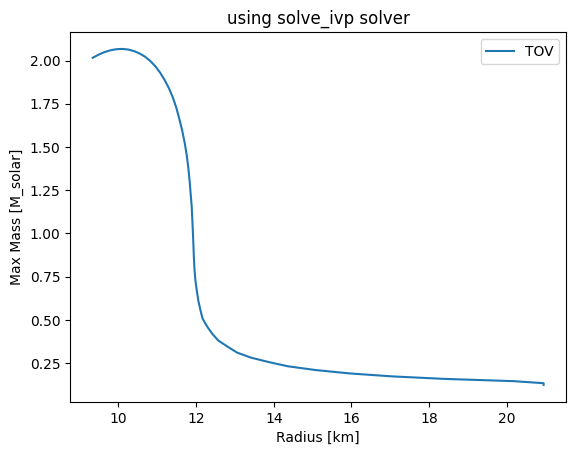

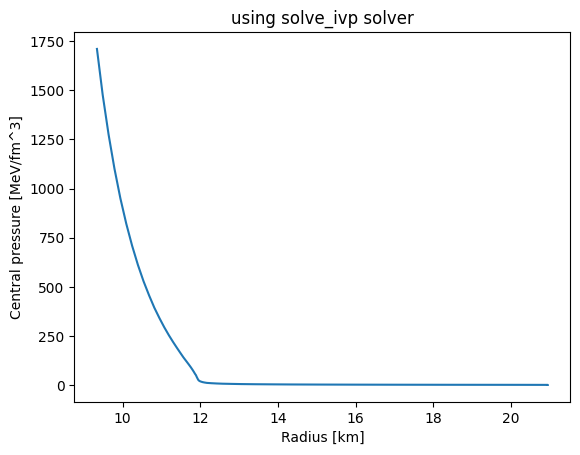

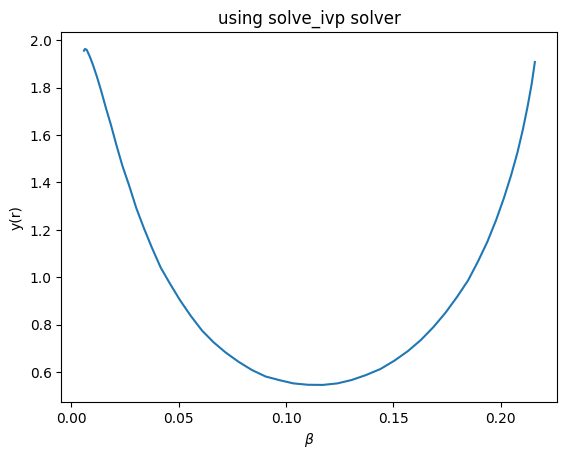

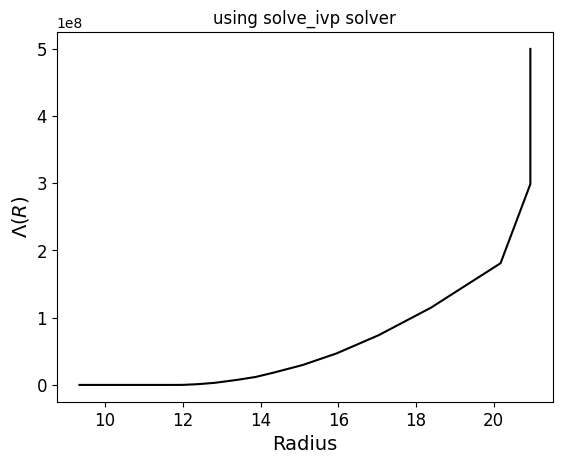

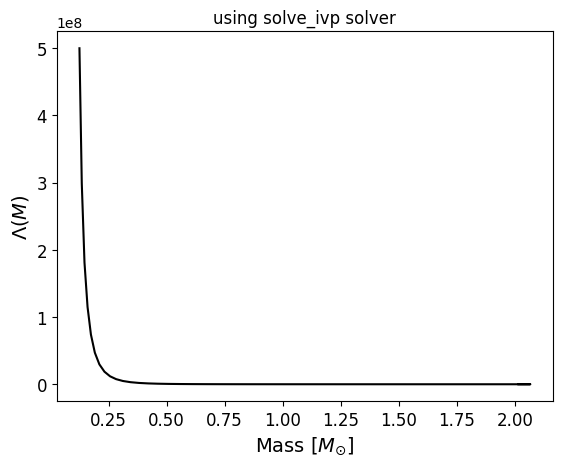

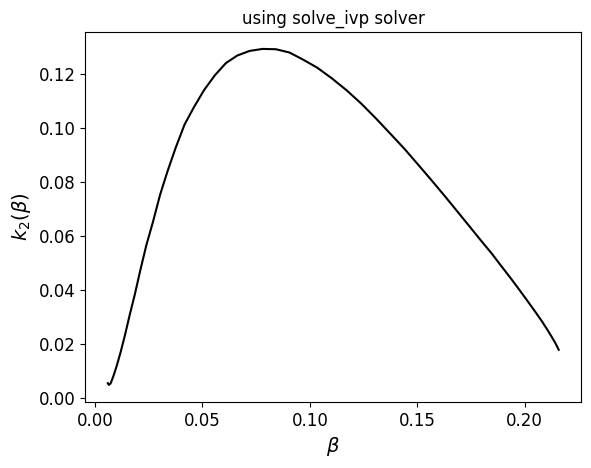

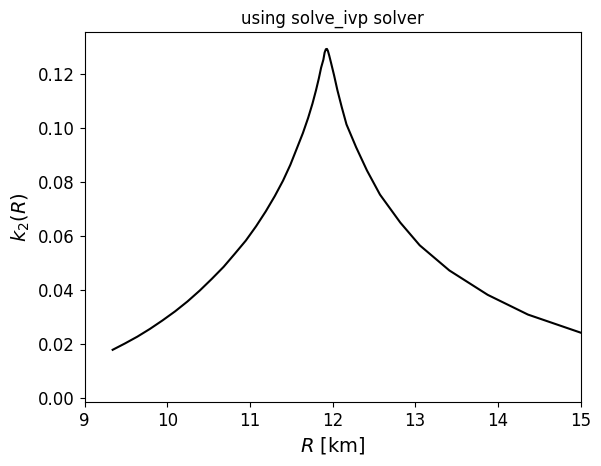

Radius:  10.09463958742699 Maximum mass:  2.0671489229936886 Central pressure:  820.9659111615389
Time: 55.391361951828 seconds
R of 1.4 solar mass star:  11.788989956000185
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671489229936886 Radius:  10.09463958742699 Central pressure:  820.9659111615389
Max mass array:  [0.12438201 0.13441997 0.14610172 0.15927655 0.17383056 0.19074185
 0.21024091 0.23215896 0.25622924 0.28215871 0.31134146 0.34434157
 0.38081089 0.42025612 0.46205357 0.50725489 0.55743886 0.61188533
 0.66966573 0.72969214 0.79195497 0.85907552 0.93004743 1.00335084
 1.07734604 1.15097601 1.22700305 1.30457301 1.38176152 1.4566611
 1.52776563 1.59723513 1.6647594  1.72863795 1.78731971 1.83963979
 1.88708769 1.92993959 1.96729459 1.99840237 2.02282181 2.04158891
 2.0552879  2.06382191 2.06714892 2.06537141 2.05892876 2.04826697
 2.03375393 2.01578583]


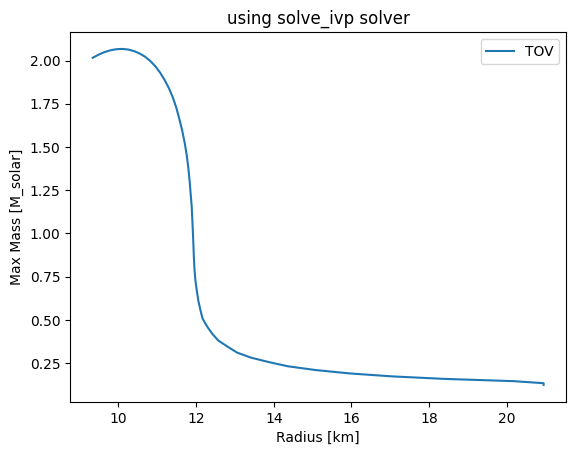

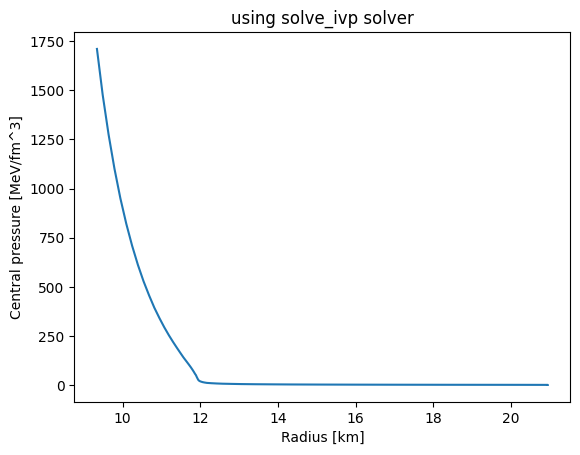

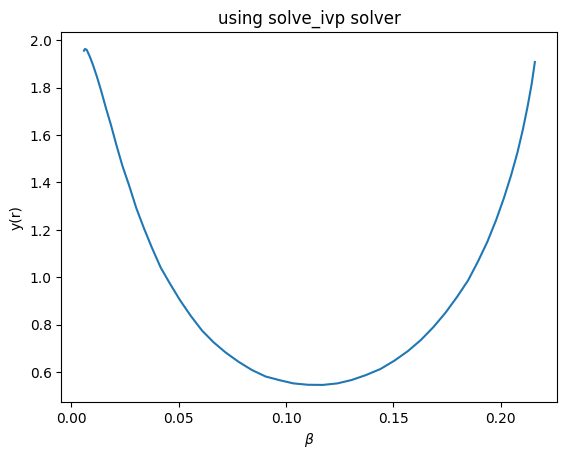

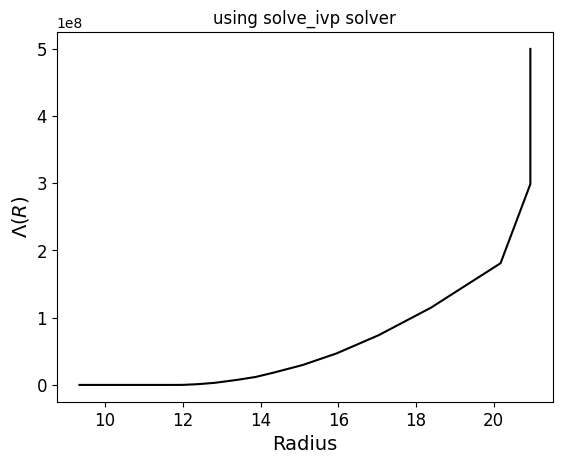

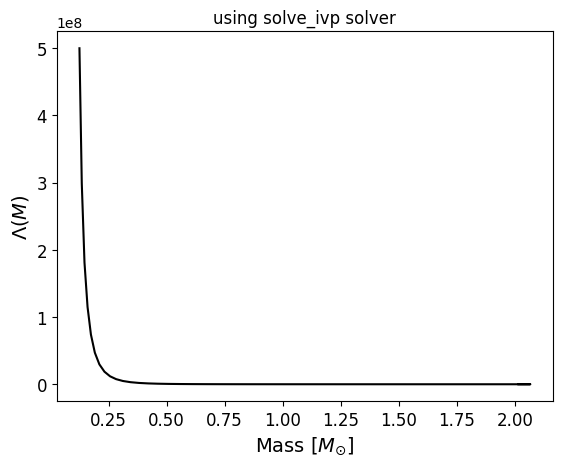

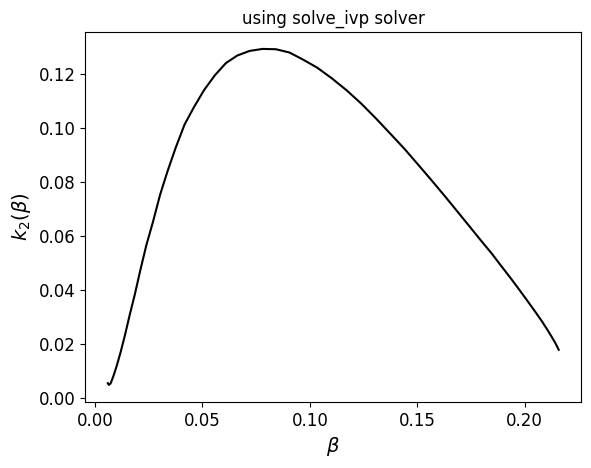

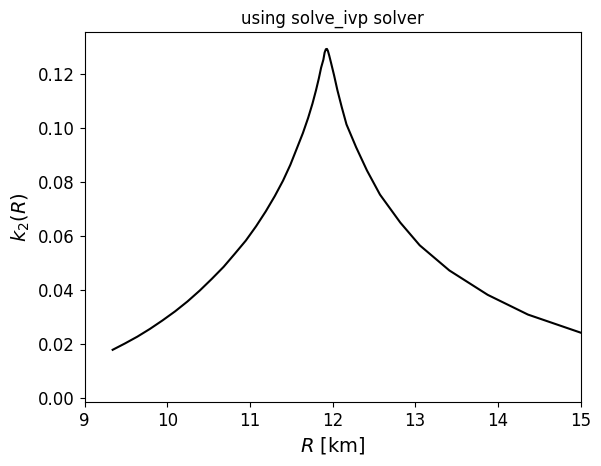

Radius:  10.09463958742699 Maximum mass:  2.0671489229936886 Central pressure:  820.9659111615389
Time: 54.875592947006226 seconds
R of 1.4 solar mass star:  11.788989956000185
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671489229936886 Radius:  10.09463958742699 Central pressure:  820.9659111615389
Max mass array:  [0.12438201 0.13441997 0.14610172 0.15927655 0.17383056 0.19074185
 0.21024091 0.23215896 0.25622924 0.28215871 0.31134146 0.34434157
 0.38081089 0.42025612 0.46205357 0.50725489 0.55743886 0.61188533
 0.66966573 0.72969214 0.79195497 0.85907552 0.93004743 1.00335084
 1.07734604 1.15097601 1.22700305 1.30457301 1.38176152 1.4566611
 1.52776563 1.59723513 1.6647594  1.72863795 1.78731971 1.83963979
 1.88708769 1.92993959 1.96729459 1.99840237 2.02282181 2.04158891
 2.0552879  2.06382191 2.06714892 2.06537141 2.05892876 2.04826697
 2.03375393 2.01578583]


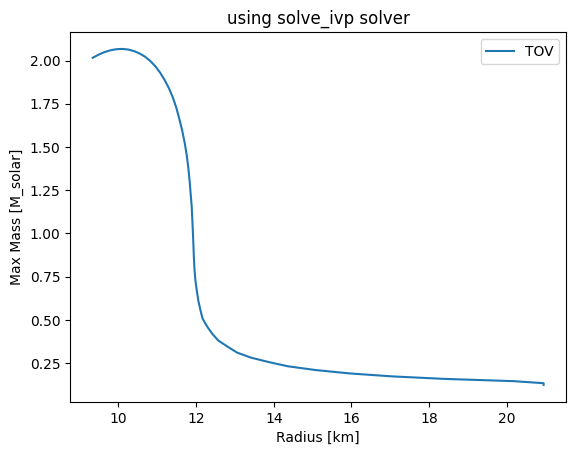

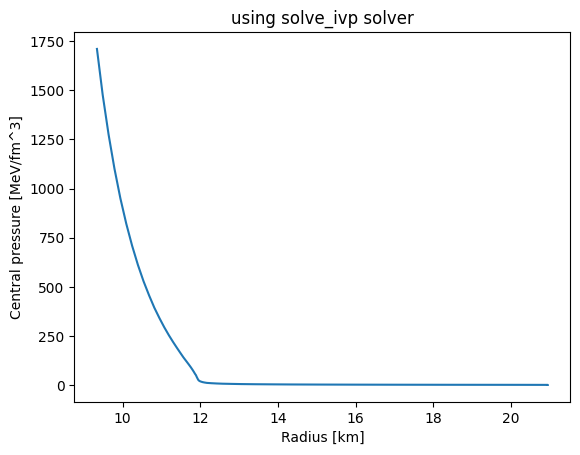

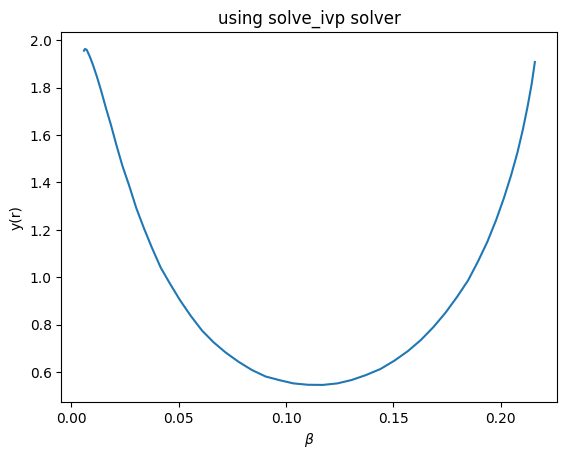

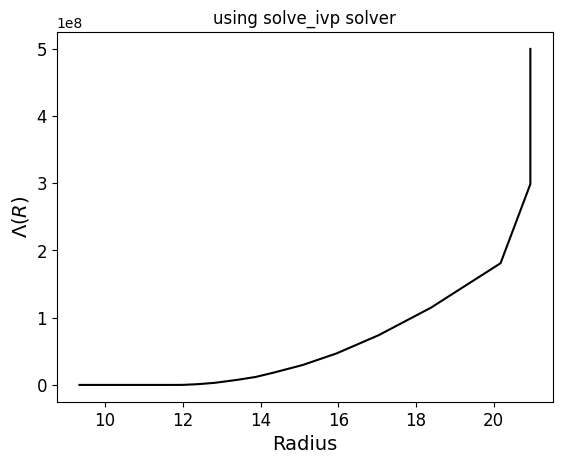

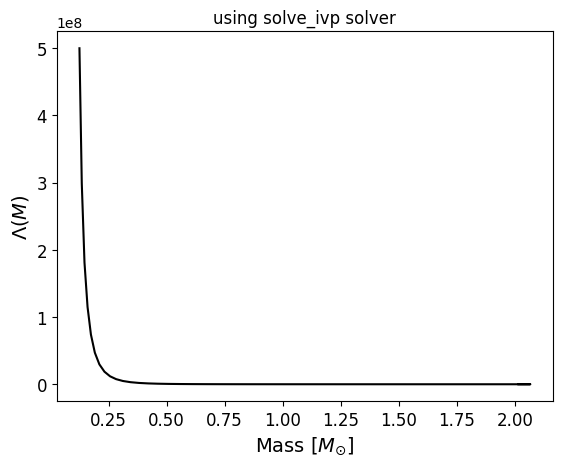

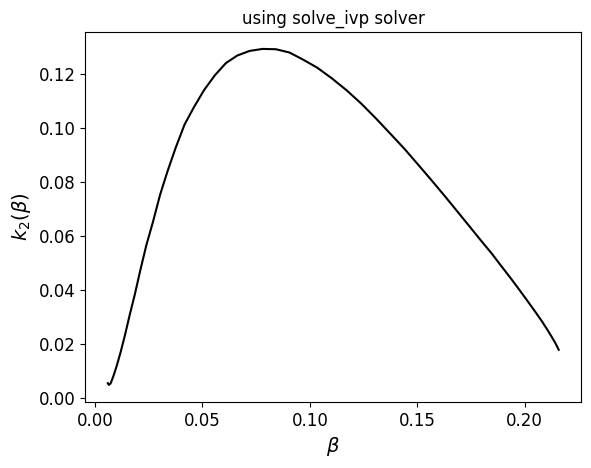

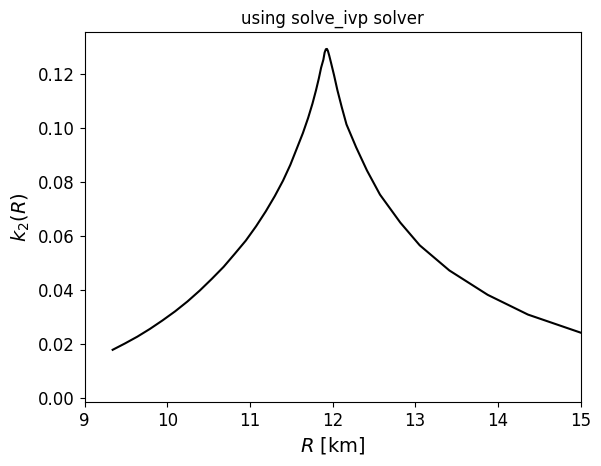

Radius:  10.09463958742699 Maximum mass:  2.0671489229936886 Central pressure:  820.9659111615389
Time: 57.4920699596405 seconds
R of 1.4 solar mass star:  11.788989956000185
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671489229936886 Radius:  10.09463958742699 Central pressure:  820.9659111615389
Max mass array:  [0.12438201 0.13441997 0.14610172 0.15927655 0.17383056 0.19074185
 0.21024091 0.23215896 0.25622924 0.28215871 0.31134146 0.34434157
 0.38081089 0.42025612 0.46205357 0.50725489 0.55743886 0.61188533
 0.66966573 0.72969214 0.79195497 0.85907552 0.93004743 1.00335084
 1.07734604 1.15097601 1.22700305 1.30457301 1.38176152 1.4566611
 1.52776563 1.59723513 1.6647594  1.72863795 1.78731971 1.83963979
 1.88708769 1.92993959 1.96729459 1.99840237 2.02282181 2.04158891
 2.0552879  2.06382191 2.06714892 2.06537141 2.05892876 2.04826697
 2.03375393 2.01578583]


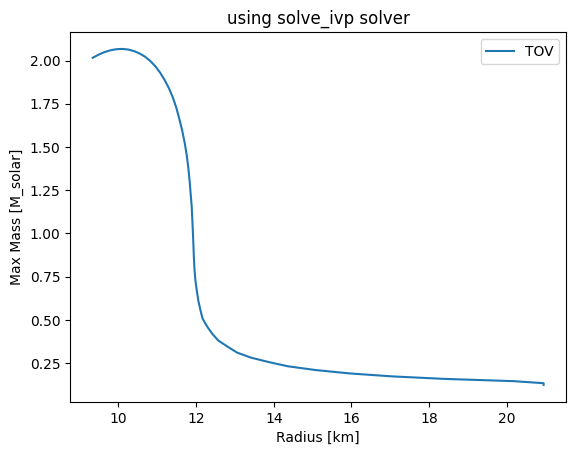

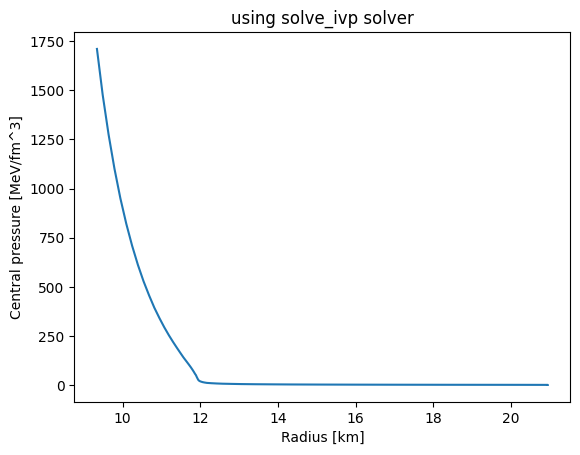

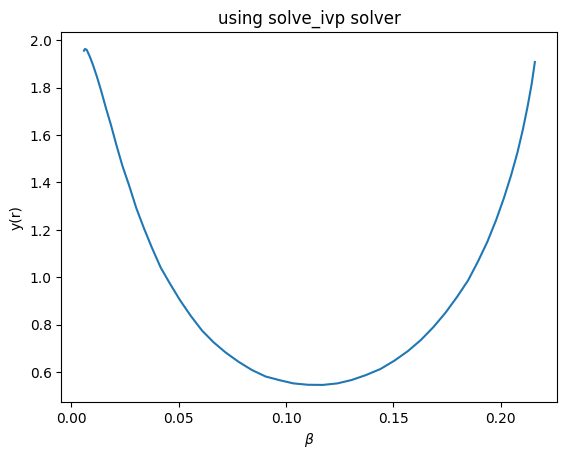

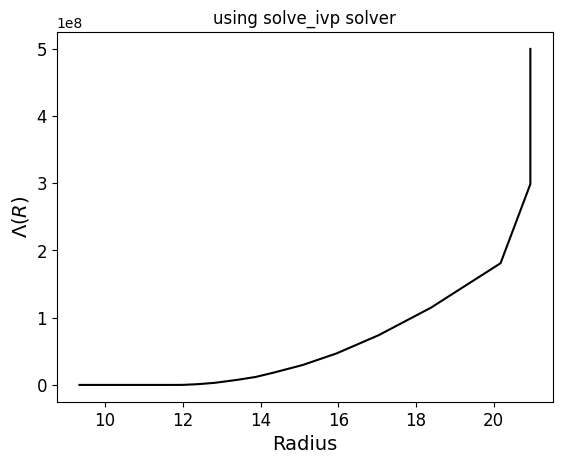

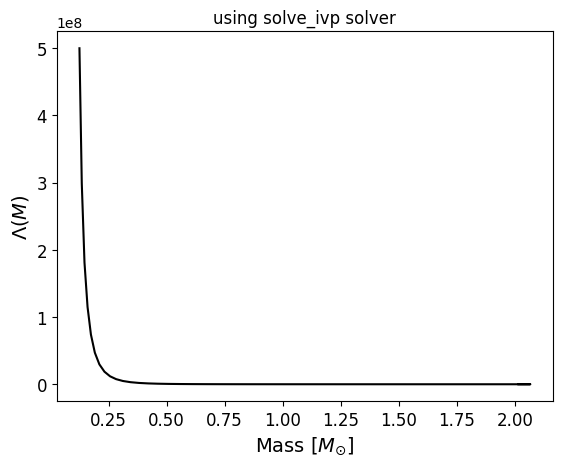

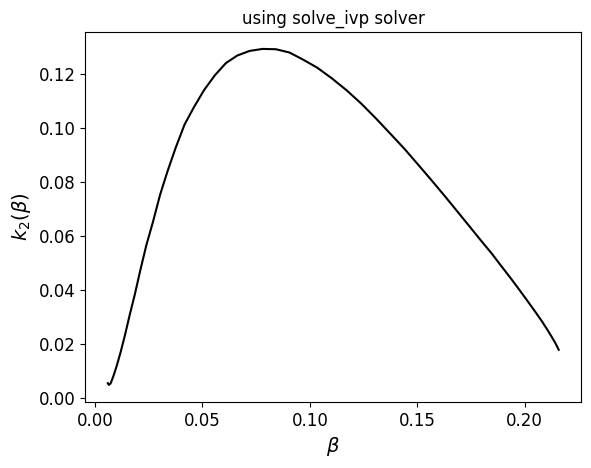

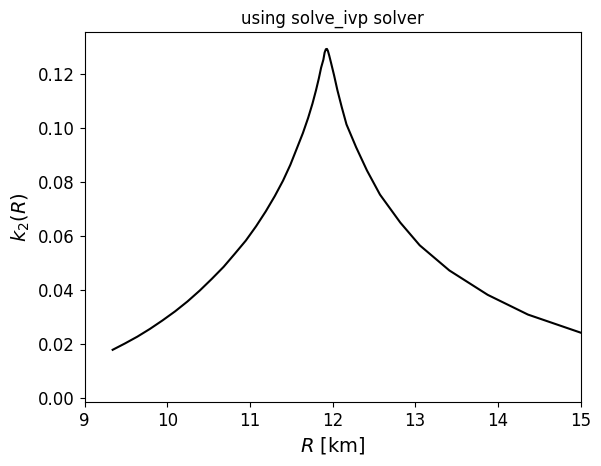

Radius:  10.09463958742699 Maximum mass:  2.0671489229936886 Central pressure:  820.9659111615389
Time: 55.5218939781189 seconds
R of 1.4 solar mass star:  11.788989956000185
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671489229936886 Radius:  10.09463958742699 Central pressure:  820.9659111615389
Max mass array:  [0.12438201 0.13441997 0.14610172 0.15927655 0.17383056 0.19074185
 0.21024091 0.23215896 0.25622924 0.28215871 0.31134146 0.34434157
 0.38081089 0.42025612 0.46205357 0.50725489 0.55743886 0.61188533
 0.66966573 0.72969214 0.79195497 0.85907552 0.93004743 1.00335084
 1.07734604 1.15097601 1.22700305 1.30457301 1.38176152 1.4566611
 1.52776563 1.59723513 1.6647594  1.72863795 1.78731971 1.83963979
 1.88708769 1.92993959 1.96729459 1.99840237 2.02282181 2.04158891
 2.0552879  2.06382191 2.06714892 2.06537141 2.05892876 2.04826697
 2.03375393 2.01578583]


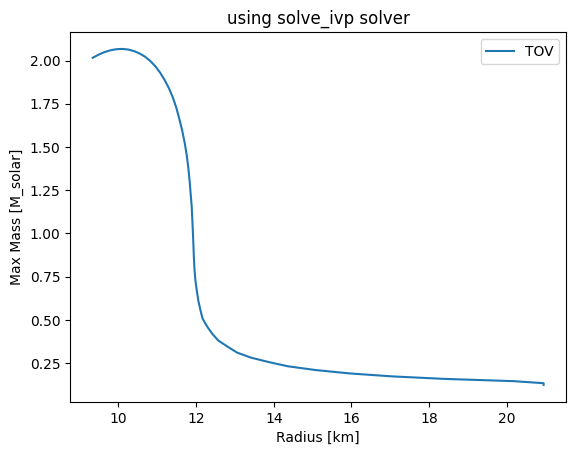

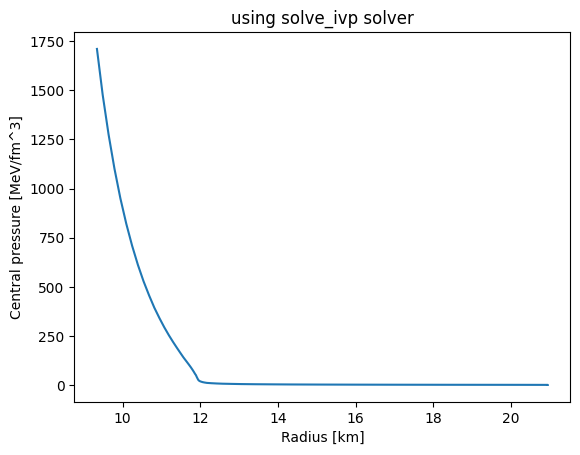

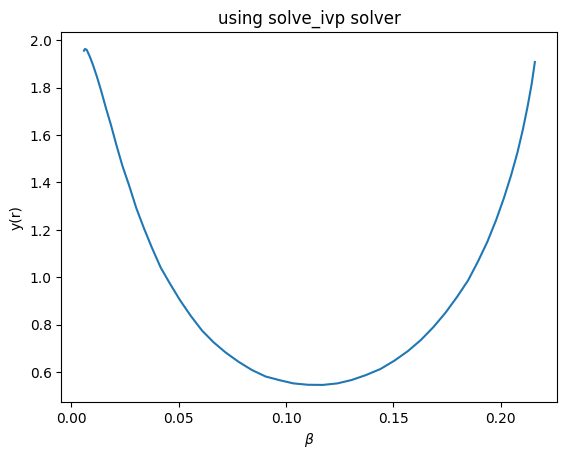

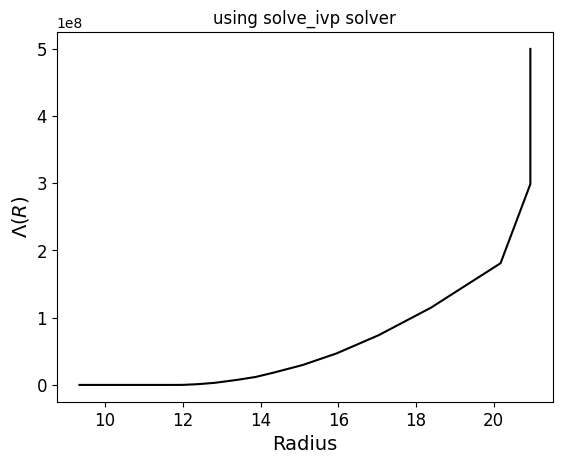

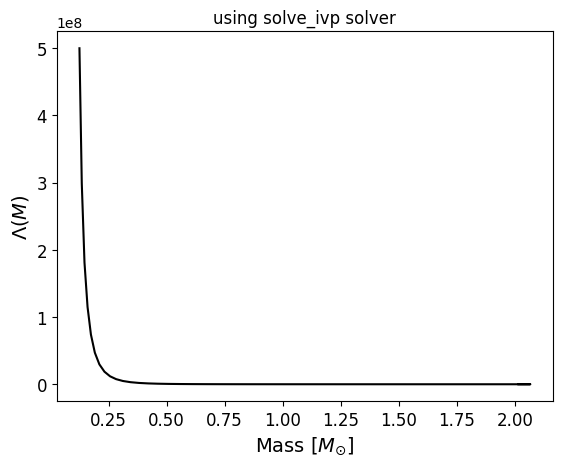

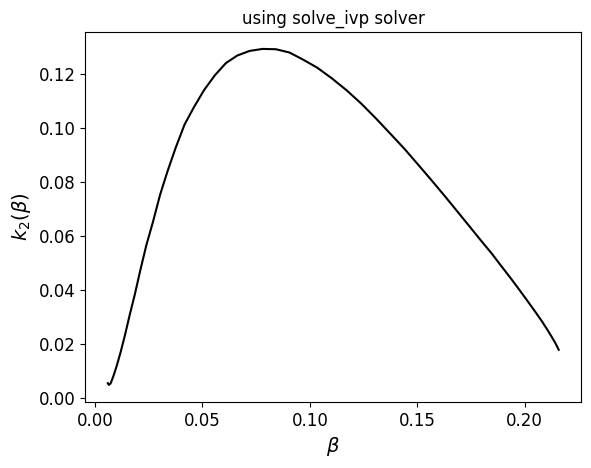

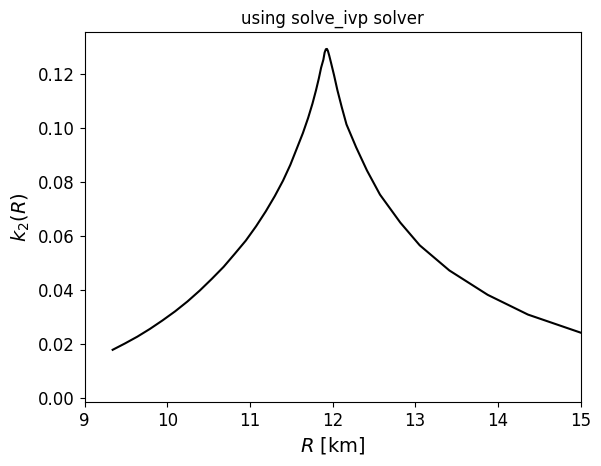

Radius:  10.09463958742699 Maximum mass:  2.0671489229936886 Central pressure:  820.9659111615389
Time: 55.447124004364014 seconds
R of 1.4 solar mass star:  11.788989956000185


In [16]:
# look at solve_ivp RK45 solver
for i in np.arange(number_of_solves):
    # some solve_ivp methods: "RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"
    tov_solveivp = TOVsolver(fileName, tidal=True, solver="solve_ivp", solve_ivp_kwargs={"method": "Radau", 
                                                                                        "atol": 1e-8, 
                                                                                        "rtol": 1e-8})
    start_time = time.time()
    tov_solveivp.tov_routine(verbose=True, write_to_file=False)
    end_time = time.time()
    print("Time: {} seconds".format(end_time - start_time))

    print("R of 1.4 solar mass star: ", tov_solveivp.canonical_NS_radius())

In [17]:
print(f"solve_ivp runtime: {np.mean(solve_ivp_runtimes):.4}s ± {np.std(solve_ivp_runtimes):.4}s")

solve_ivp runtime: 55.37s ± 0.8872s


/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.067148972489221 Radius:  10.092968221999998 Central pressure:  820.9659111615389
Max mass array:  [0.12442439 0.13442581 0.14610169 0.15927658 0.17383054 0.19074181
 0.2102409  0.23215899 0.2562292  0.28215871 0.31134147 0.34434155
 0.38081085 0.42025613 0.46205357 0.50725488 0.55743887 0.61188532
 0.6696657  0.72969214 0.79195479 0.85907523 0.9300474  1.00335079
 1.07734607 1.150976   1.22700284 1.30457281 1.38176154 1.45666099
 1.52776549 1.59723499 1.66475941 1.728638   1.78731967 1.83963973
 1.88708773 1.92993961 1.96729458 1.99840236 2.02282172 2.04158899
 2.05528793 2.06382165 2.06714897 2.06537129 2.05892875 2.04826702
 2.03375379 2.01578589]


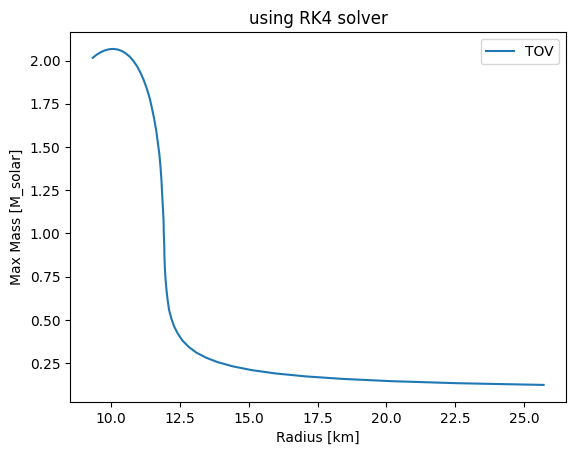

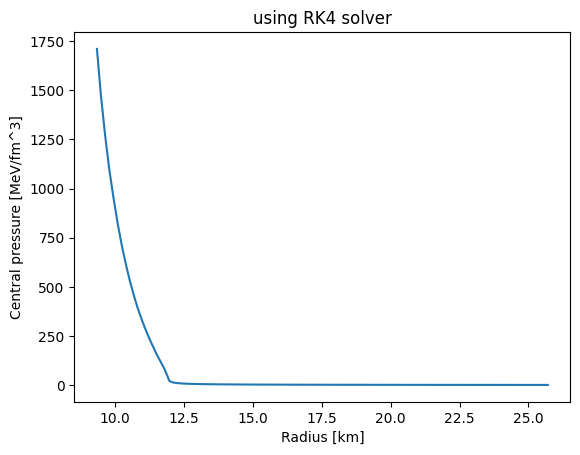

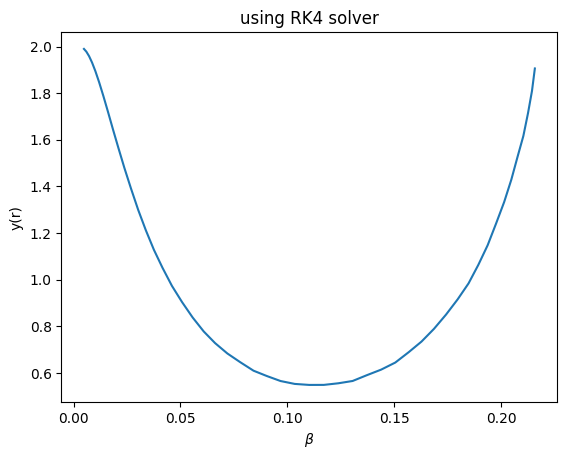

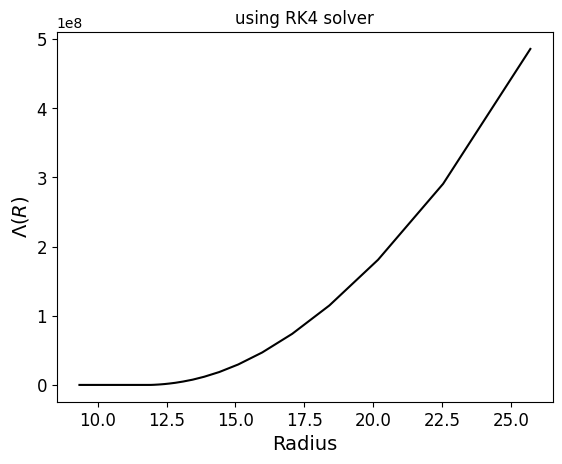

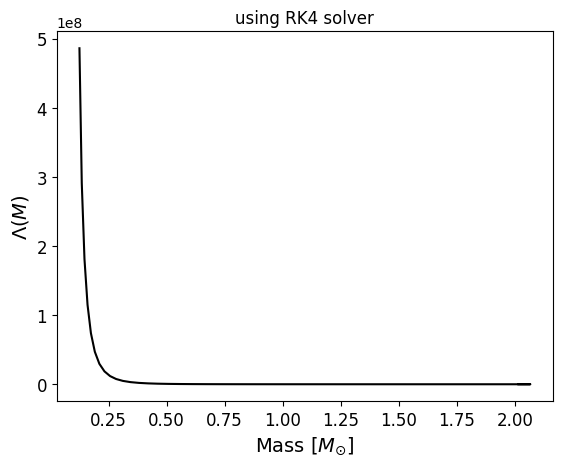

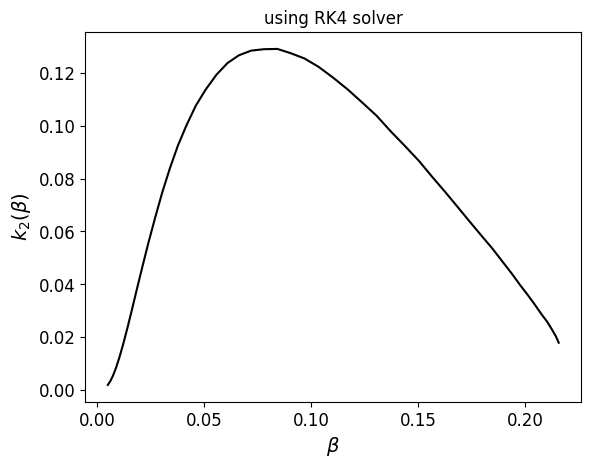

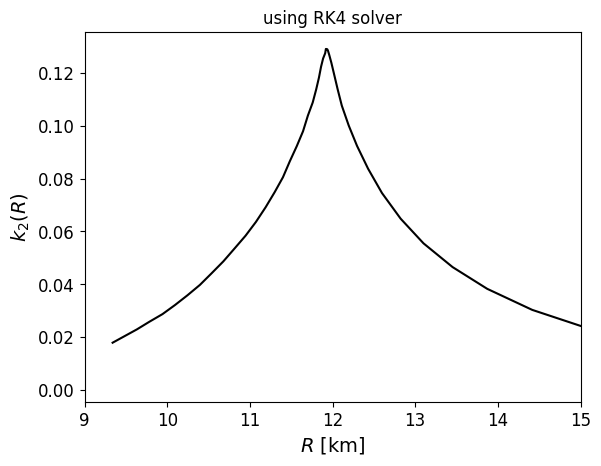

Radius:  10.092968221999998 Maximum mass:  2.067148972489221 Central pressure:  820.9659111615389
Time: 18.22518515586853 seconds
R of 1.4 solar mass star:  11.791455032959743
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.067148972489221 Radius:  10.092968221999998 Central pressure:  820.9659111615389
Max mass array:  [0.12442439 0.13442581 0.14610169 0.15927658 0.17383054 0.19074181
 0.2102409  0.23215899 0.2562292  0.28215871 0.31134147 0.34434155
 0.38081085 0.42025613 0.46205357 0.50725488 0.55743887 0.61188532
 0.6696657  0.72969214 0.79195479 0.85907523 0.9300474  1.00335079
 1.07734607 1.150976   1.22700284 1.30457281 1.38176154 1.45666099
 1.52776549 1.59723499 1.66475941 1.728638   1.78731967 1.83963973
 1.88708773 1.92993961 1.96729458 1.99840236 2.02282172 2.04158899
 2.05528793 2.06382165 2.06714897 2.06537129 2.05892875 2.04826702
 2.03375379 2.01578589]


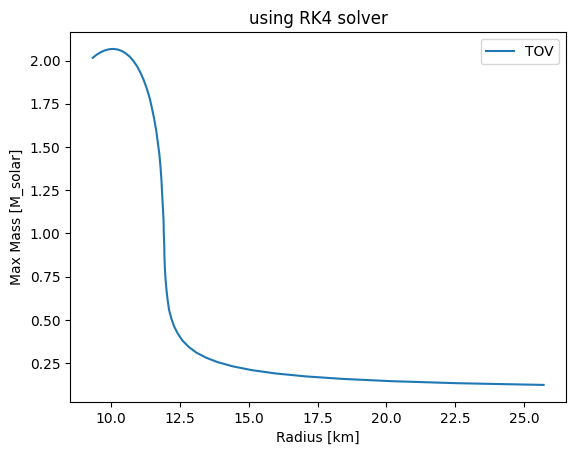

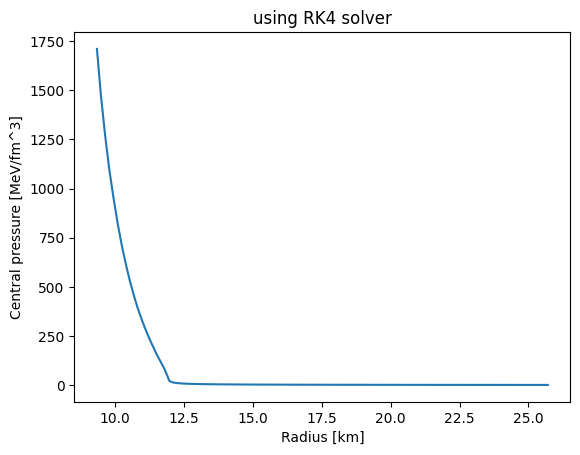

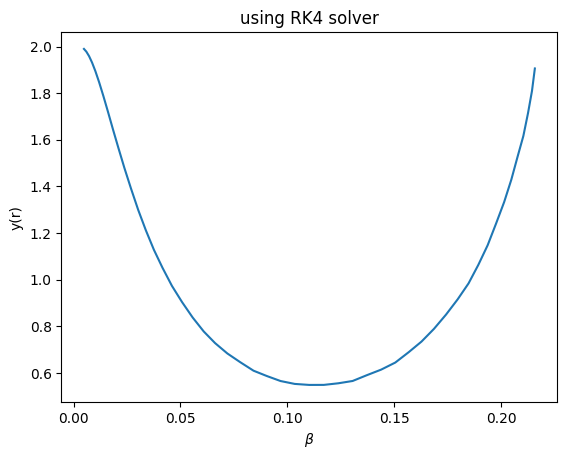

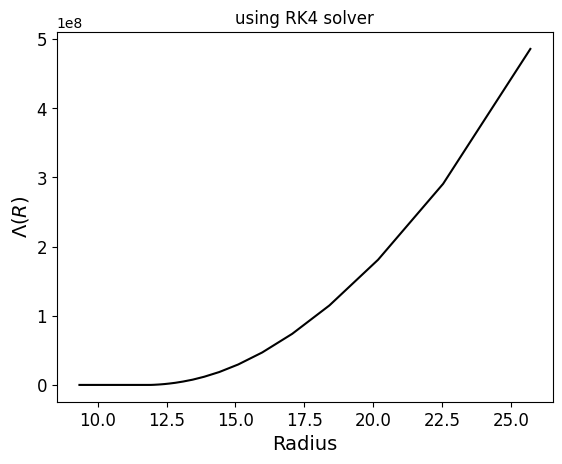

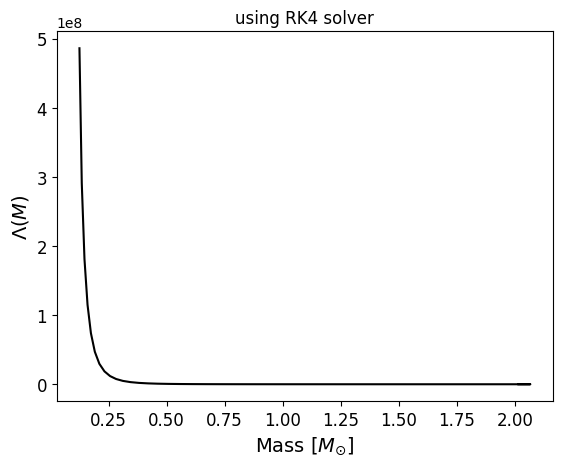

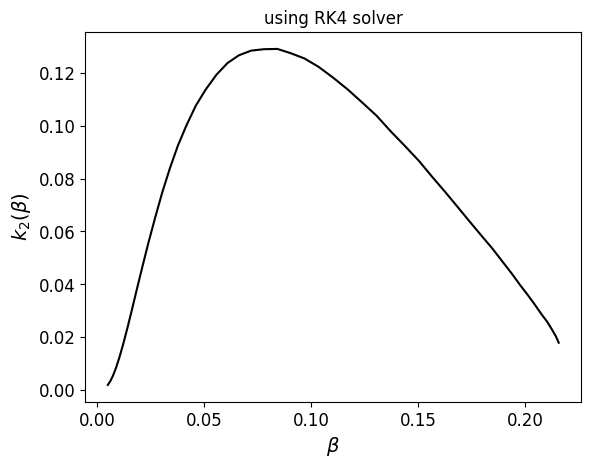

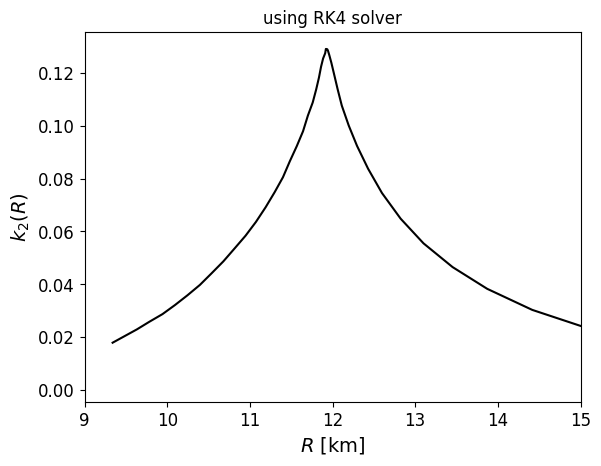

Radius:  10.092968221999998 Maximum mass:  2.067148972489221 Central pressure:  820.9659111615389
Time: 18.374430894851685 seconds
R of 1.4 solar mass star:  11.791455032959743
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.067148972489221 Radius:  10.092968221999998 Central pressure:  820.9659111615389
Max mass array:  [0.12442439 0.13442581 0.14610169 0.15927658 0.17383054 0.19074181
 0.2102409  0.23215899 0.2562292  0.28215871 0.31134147 0.34434155
 0.38081085 0.42025613 0.46205357 0.50725488 0.55743887 0.61188532
 0.6696657  0.72969214 0.79195479 0.85907523 0.9300474  1.00335079
 1.07734607 1.150976   1.22700284 1.30457281 1.38176154 1.45666099
 1.52776549 1.59723499 1.66475941 1.728638   1.78731967 1.83963973
 1.88708773 1.92993961 1.96729458 1.99840236 2.02282172 2.04158899
 2.05528793 2.06382165 2.06714897 2.06537129 2.05892875 2.04826702
 2.03375379 2.01578589]


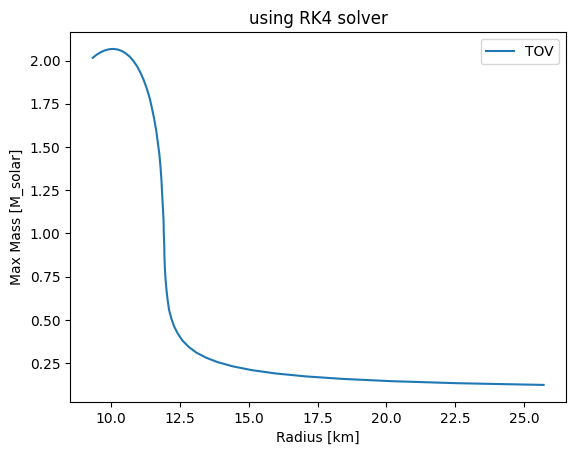

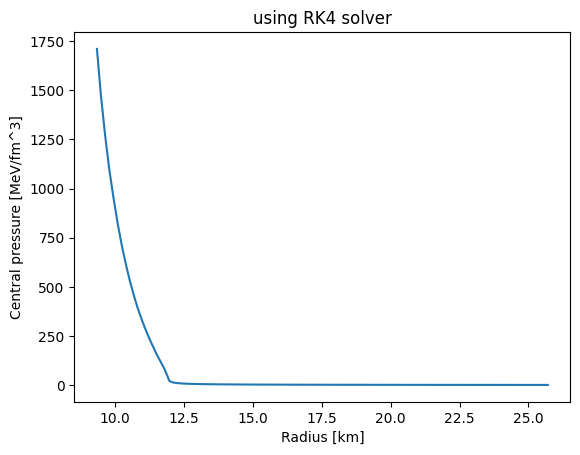

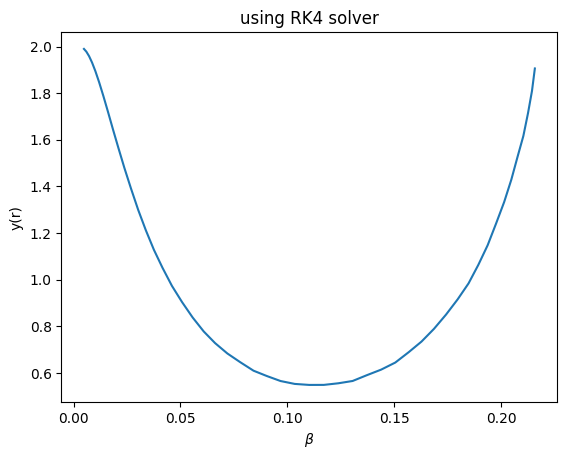

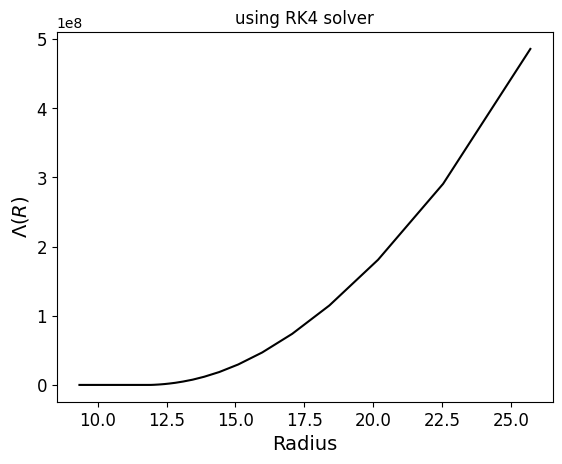

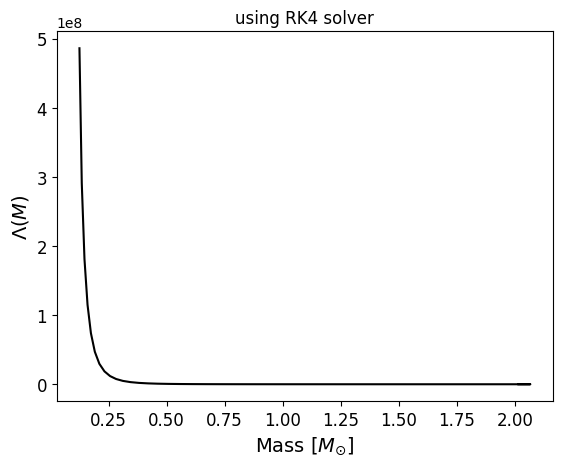

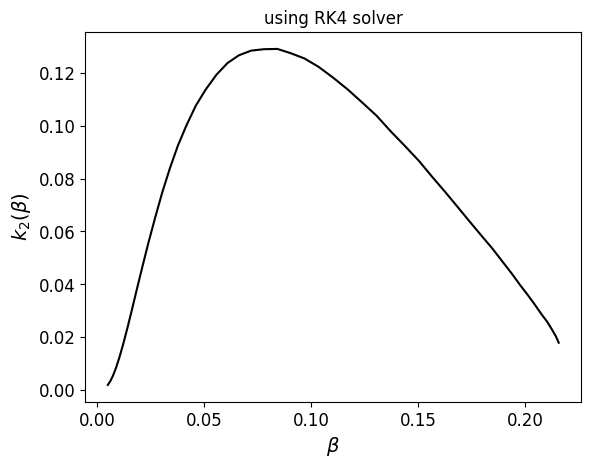

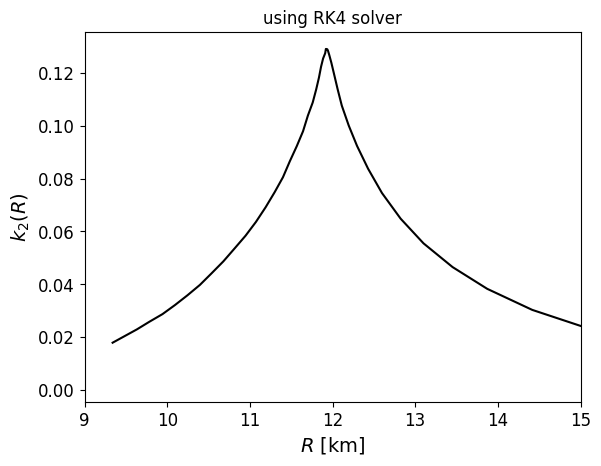

Radius:  10.092968221999998 Maximum mass:  2.067148972489221 Central pressure:  820.9659111615389
Time: 17.925116062164307 seconds
R of 1.4 solar mass star:  11.791455032959743
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.067148972489221 Radius:  10.092968221999998 Central pressure:  820.9659111615389
Max mass array:  [0.12442439 0.13442581 0.14610169 0.15927658 0.17383054 0.19074181
 0.2102409  0.23215899 0.2562292  0.28215871 0.31134147 0.34434155
 0.38081085 0.42025613 0.46205357 0.50725488 0.55743887 0.61188532
 0.6696657  0.72969214 0.79195479 0.85907523 0.9300474  1.00335079
 1.07734607 1.150976   1.22700284 1.30457281 1.38176154 1.45666099
 1.52776549 1.59723499 1.66475941 1.728638   1.78731967 1.83963973
 1.88708773 1.92993961 1.96729458 1.99840236 2.02282172 2.04158899
 2.05528793 2.06382165 2.06714897 2.06537129 2.05892875 2.04826702
 2.03375379 2.01578589]


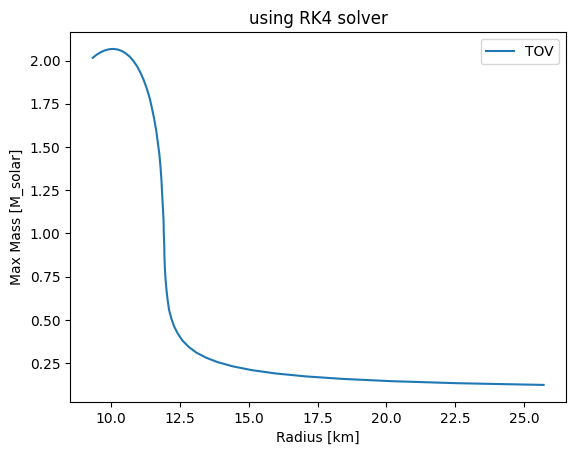

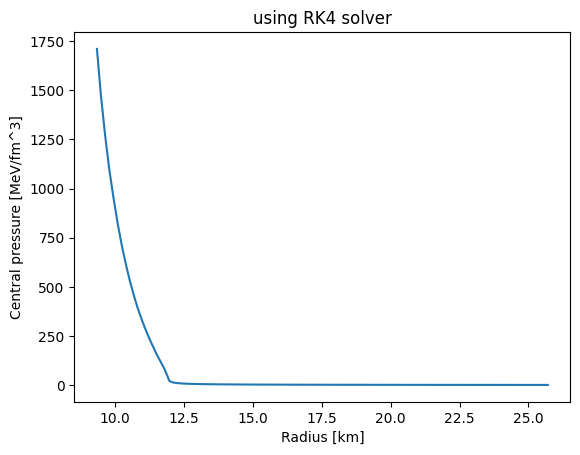

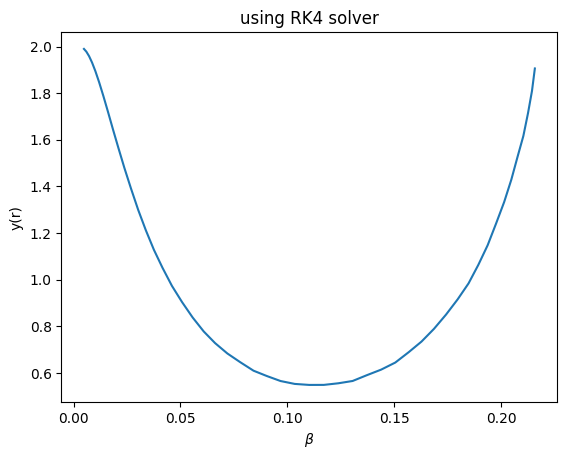

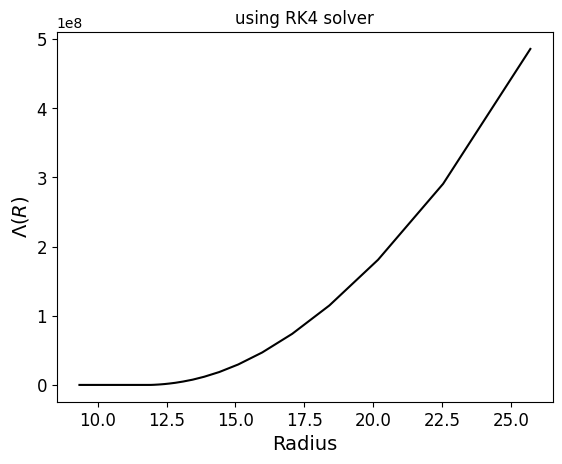

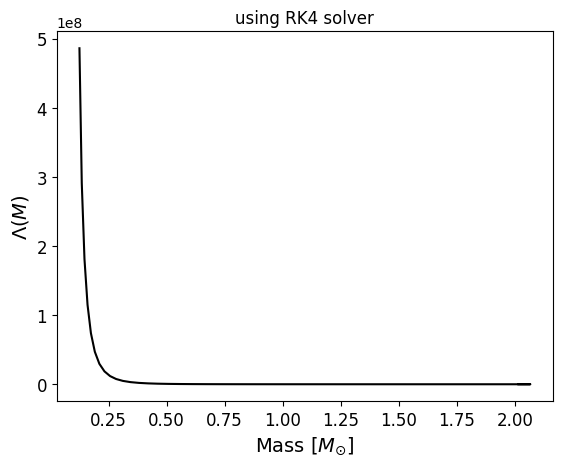

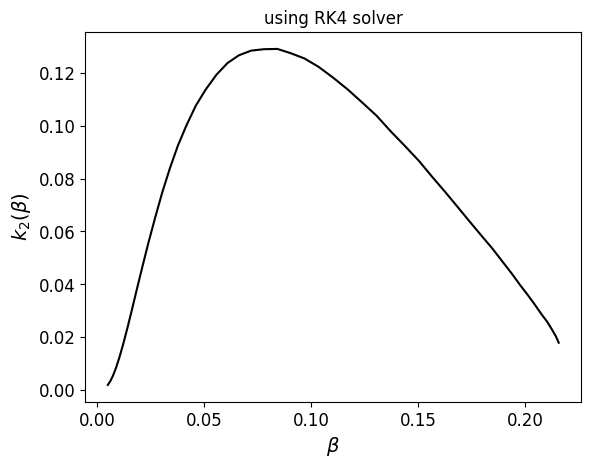

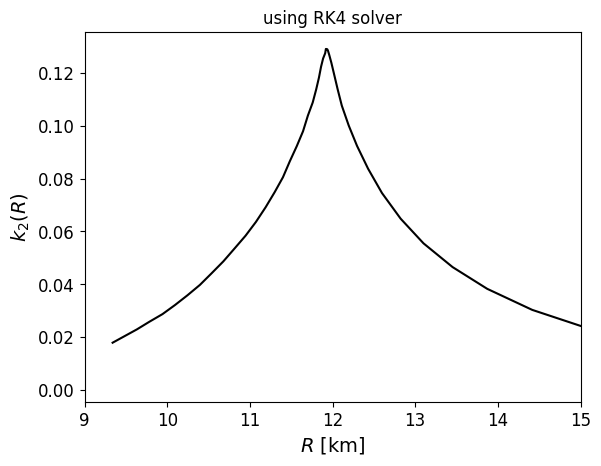

Radius:  10.092968221999998 Maximum mass:  2.067148972489221 Central pressure:  820.9659111615389
Time: 18.093136072158813 seconds
R of 1.4 solar mass star:  11.791455032959743
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.067148972489221 Radius:  10.092968221999998 Central pressure:  820.9659111615389
Max mass array:  [0.12442439 0.13442581 0.14610169 0.15927658 0.17383054 0.19074181
 0.2102409  0.23215899 0.2562292  0.28215871 0.31134147 0.34434155
 0.38081085 0.42025613 0.46205357 0.50725488 0.55743887 0.61188532
 0.6696657  0.72969214 0.79195479 0.85907523 0.9300474  1.00335079
 1.07734607 1.150976   1.22700284 1.30457281 1.38176154 1.45666099
 1.52776549 1.59723499 1.66475941 1.728638   1.78731967 1.83963973
 1.88708773 1.92993961 1.96729458 1.99840236 2.02282172 2.04158899
 2.05528793 2.06382165 2.06714897 2.06537129 2.05892875 2.04826702
 2.03375379 2.01578589]


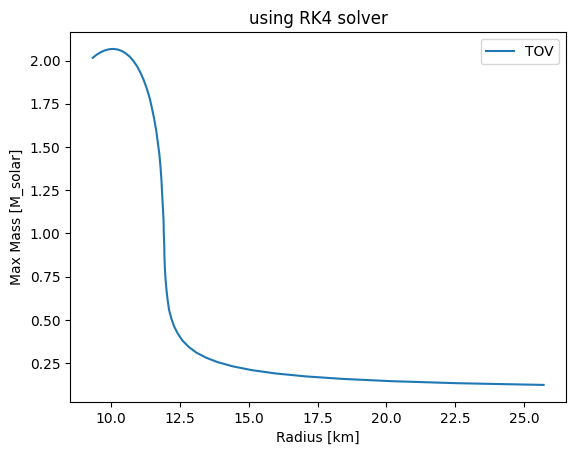

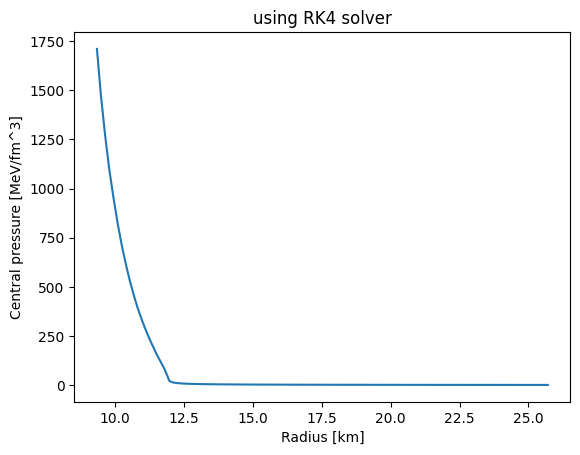

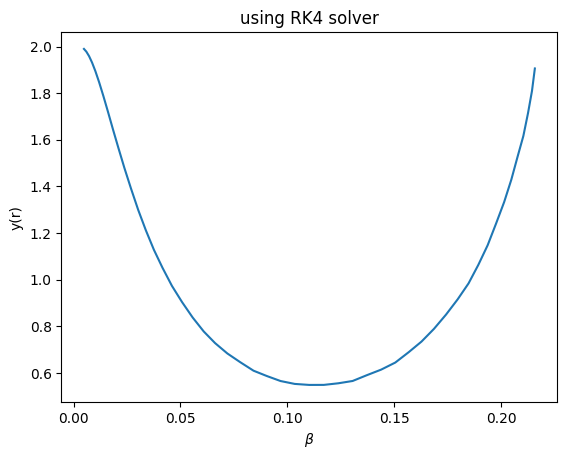

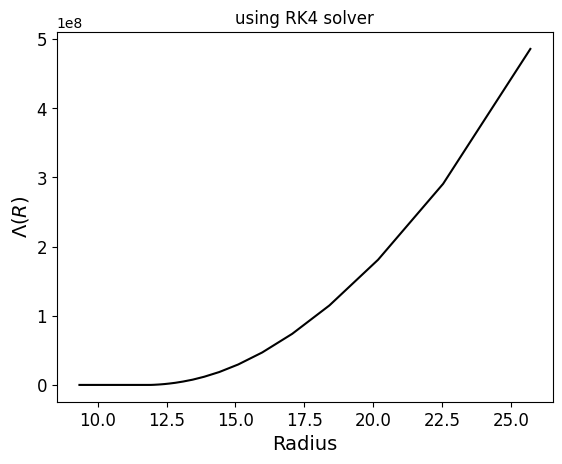

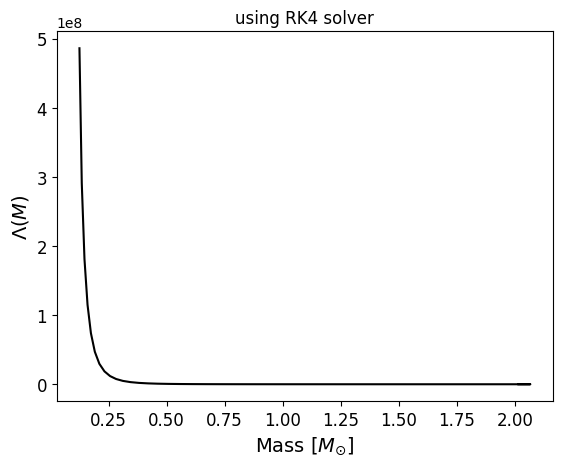

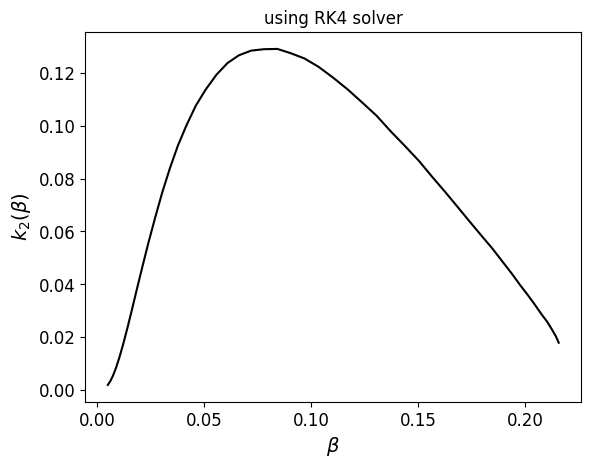

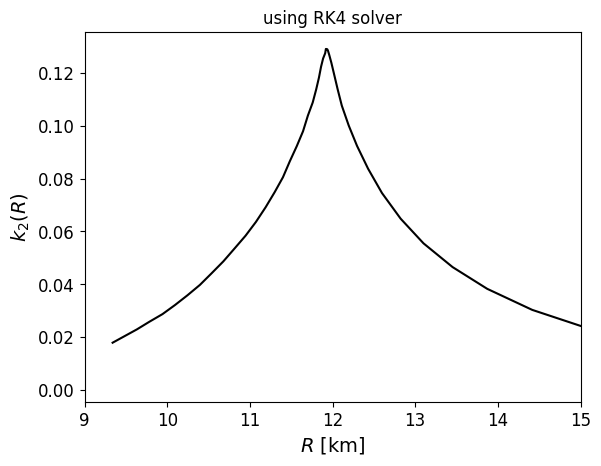

Radius:  10.092968221999998 Maximum mass:  2.067148972489221 Central pressure:  820.9659111615389
Time: 17.997734308242798 seconds
R of 1.4 solar mass star:  11.791455032959743


In [ ]:
# look at RK4 solver (the original one)
for i in np.arange(number_of_solves):
    tov_rk4 = TOVsolver(fileName, tidal=True, solver="RK4")
    start_time = time.time()
    tov_rk4.tov_routine(verbose=True, write_to_file=False)
    end_time = time.time()
    print("Time: {} seconds".format(end_time - start_time))

    print("R of 1.4 solar mass star: ", tov_rk4.canonical_NS_radius())

In [9]:
print(f"RK4 runtime: {np.mean(rk4_runtimes):.4}s ± {np.std(rk4_runtimes):.4}s")

RK4 runtime: 17.73s ± 0.157s


/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671529454228352 Radius:  10.109720032999997 Central pressure:  820.9659111615389
Max mass array:  [0.12442629 0.13442794 0.14610401 0.15927911 0.17383328 0.19074475
 0.21024412 0.23216249 0.25623283 0.28216254 0.31134561 0.34434591
 0.38081544 0.42026094 0.46205856 0.50726007 0.55744434 0.61189093
 0.66967149 0.72969801 0.79196073 0.85908146 0.93005371 1.00335704
 1.07735244 1.15098225 1.22700919 1.30457919 1.38176784 1.45666698
 1.52777148 1.59724067 1.66476511 1.72864363 1.78732498 1.83964473
 1.88709274 1.92994439 1.96729917 1.99840696 2.02282611 2.0415933
 2.05529204 2.06382561 2.06715295 2.06537497 2.05893244 2.04827093
 2.03375753 2.01578969]


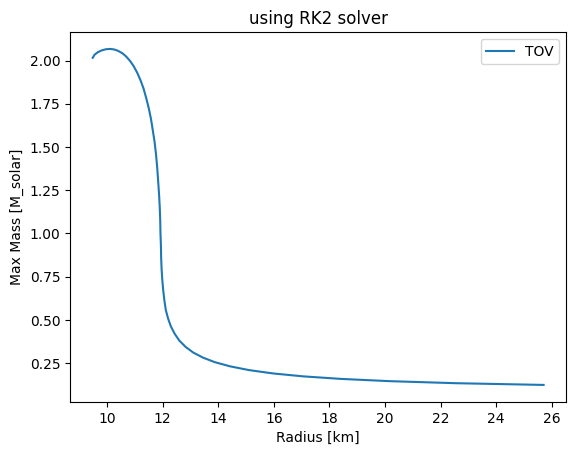

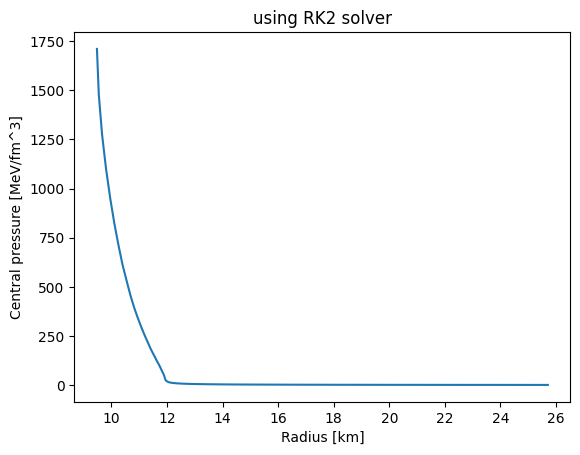

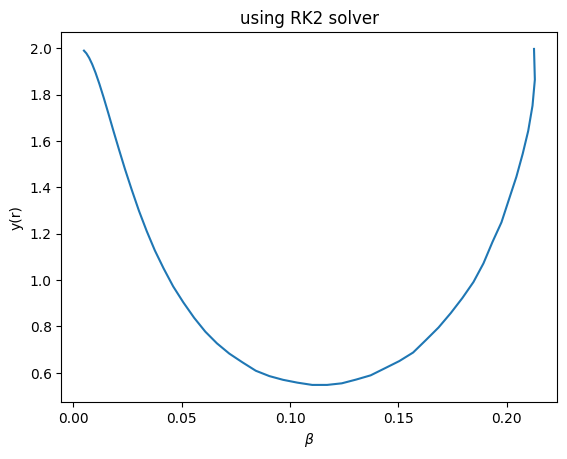

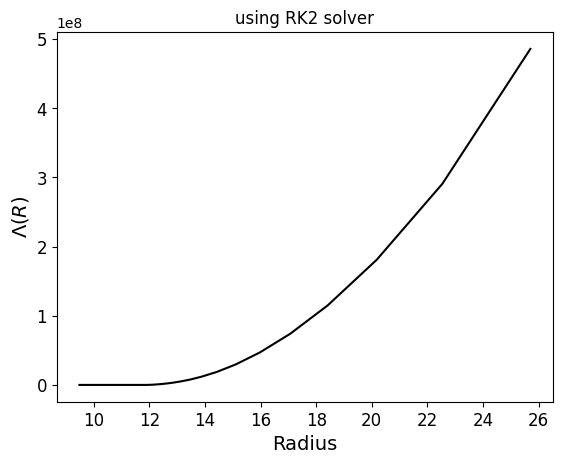

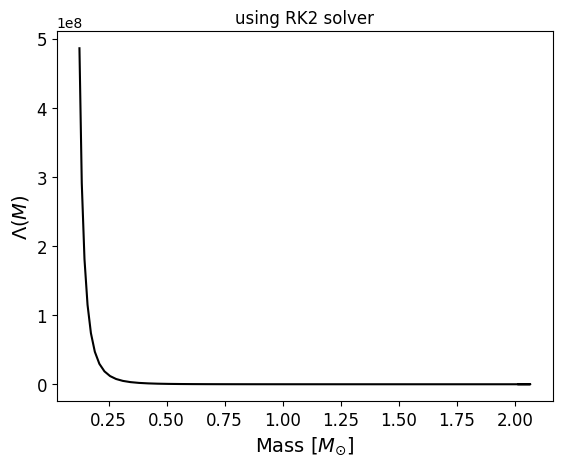

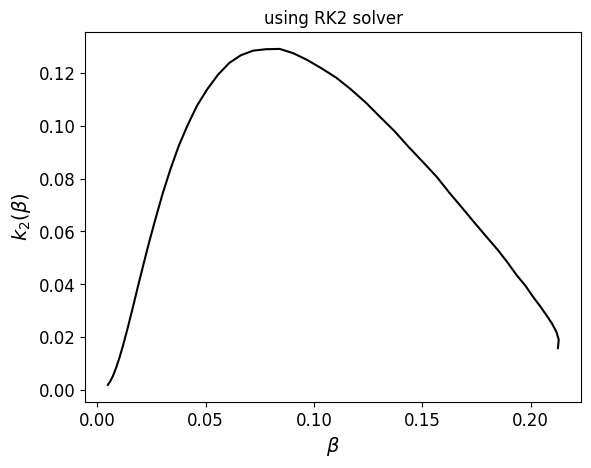

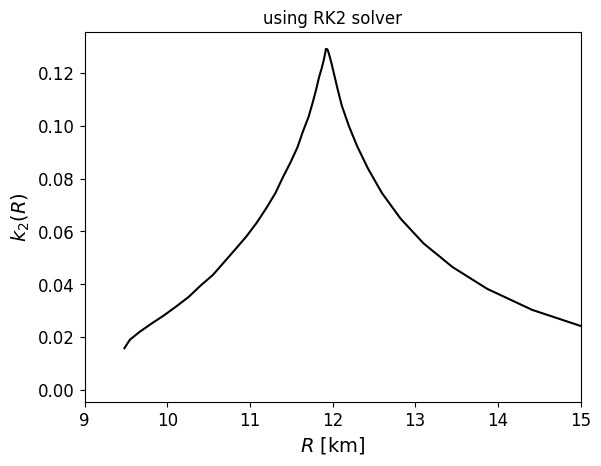

Radius:  10.109720032999997 Maximum mass:  2.0671529454228352 Central pressure:  820.9659111615389
Time: 9.713151216506958 seconds
R of 1.4 solar mass star:  11.791458510710168
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671529454228352 Radius:  10.109720032999997 Central pressure:  820.9659111615389
Max mass array:  [0.12442629 0.13442794 0.14610401 0.15927911 0.17383328 0.19074475
 0.21024412 0.23216249 0.25623283 0.28216254 0.31134561 0.34434591
 0.38081544 0.42026094 0.46205856 0.50726007 0.55744434 0.61189093
 0.66967149 0.72969801 0.79196073 0.85908146 0.93005371 1.00335704
 1.07735244 1.15098225 1.22700919 1.30457919 1.38176784 1.45666698
 1.52777148 1.59724067 1.66476511 1.72864363 1.78732498 1.83964473
 1.88709274 1.92994439 1.96729917 1.99840696 2.02282611 2.0415933
 2.05529204 2.06382561 2.06715295 2.06537497 2.05893244 2.04827093
 2.03375753 2.01578969]


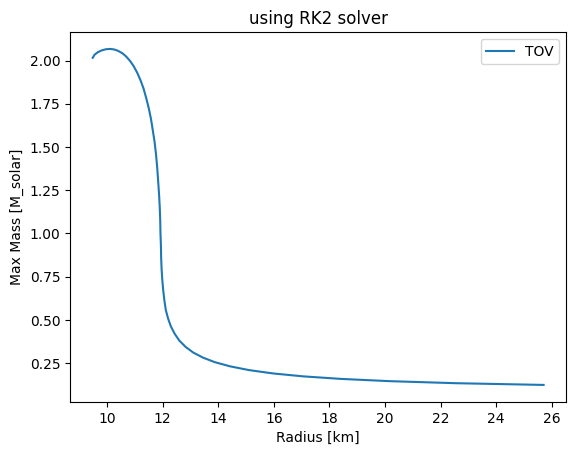

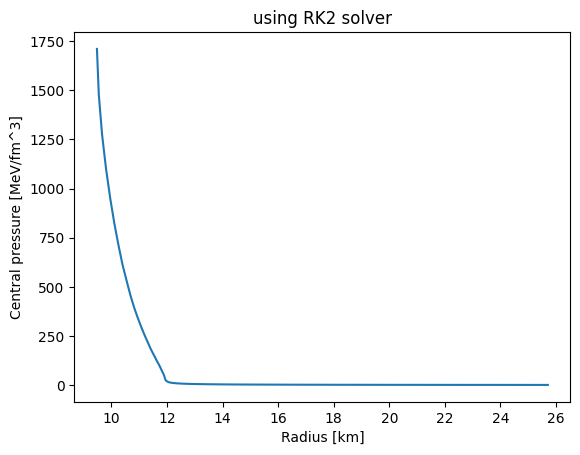

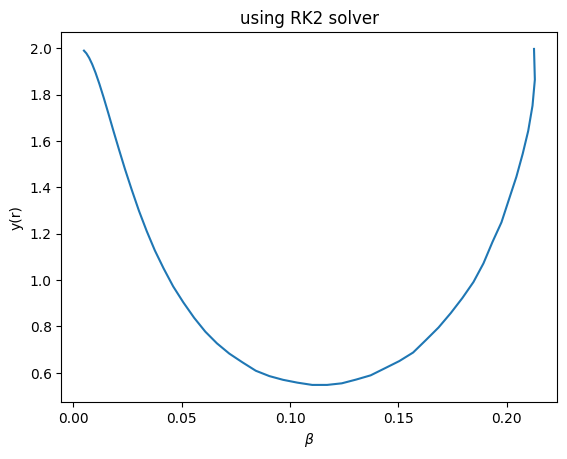

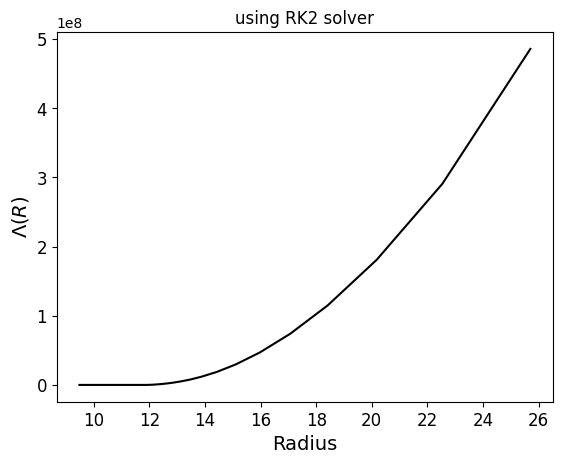

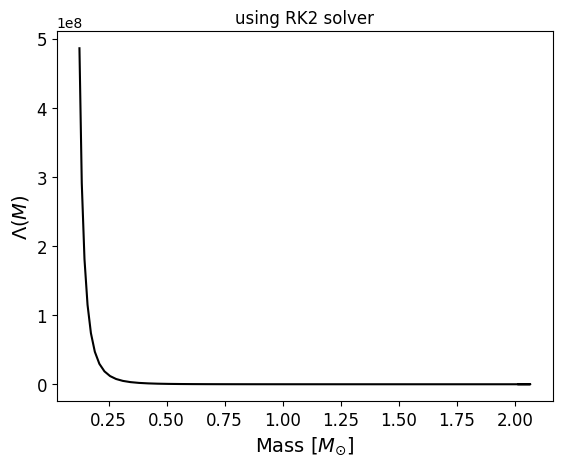

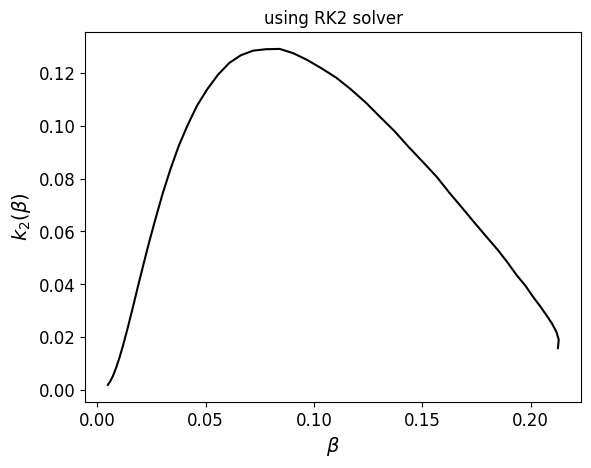

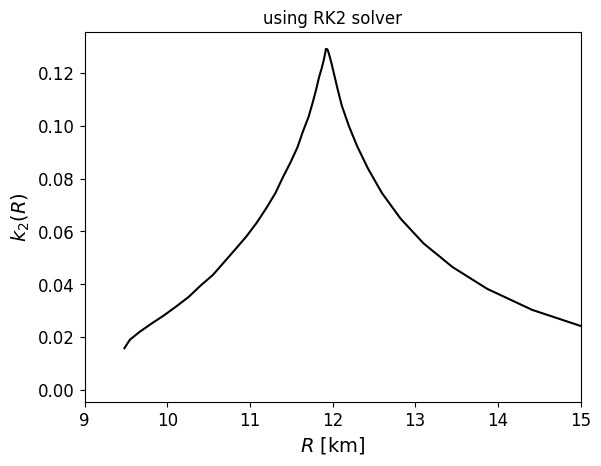

Radius:  10.109720032999997 Maximum mass:  2.0671529454228352 Central pressure:  820.9659111615389
Time: 9.66124701499939 seconds
R of 1.4 solar mass star:  11.791458510710168
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671529454228352 Radius:  10.109720032999997 Central pressure:  820.9659111615389
Max mass array:  [0.12442629 0.13442794 0.14610401 0.15927911 0.17383328 0.19074475
 0.21024412 0.23216249 0.25623283 0.28216254 0.31134561 0.34434591
 0.38081544 0.42026094 0.46205856 0.50726007 0.55744434 0.61189093
 0.66967149 0.72969801 0.79196073 0.85908146 0.93005371 1.00335704
 1.07735244 1.15098225 1.22700919 1.30457919 1.38176784 1.45666698
 1.52777148 1.59724067 1.66476511 1.72864363 1.78732498 1.83964473
 1.88709274 1.92994439 1.96729917 1.99840696 2.02282611 2.0415933
 2.05529204 2.06382561 2.06715295 2.06537497 2.05893244 2.04827093
 2.03375753 2.01578969]


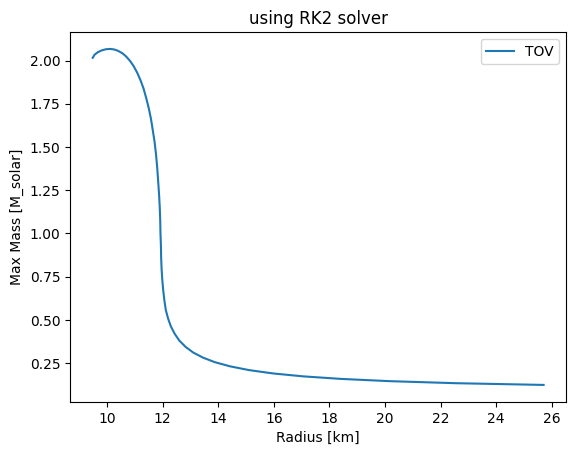

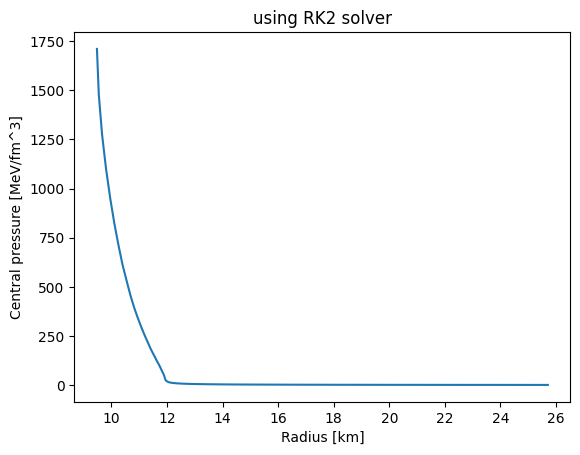

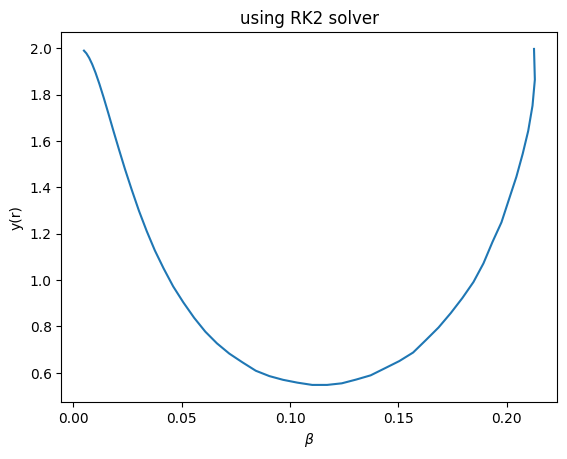

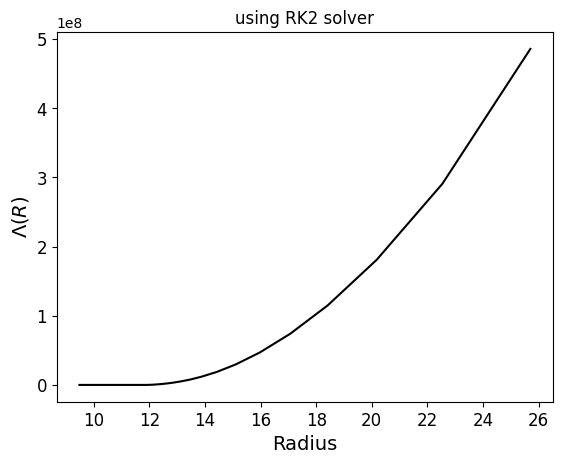

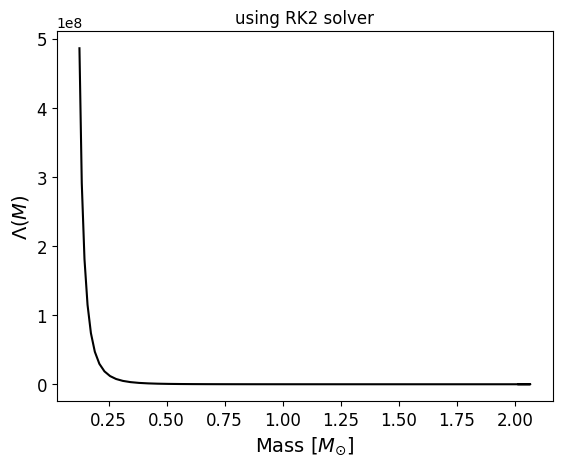

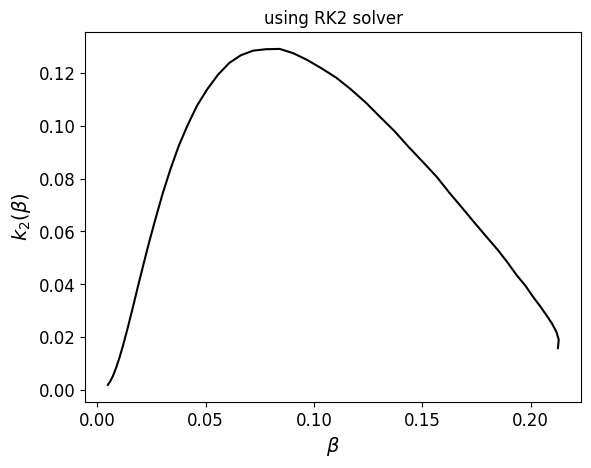

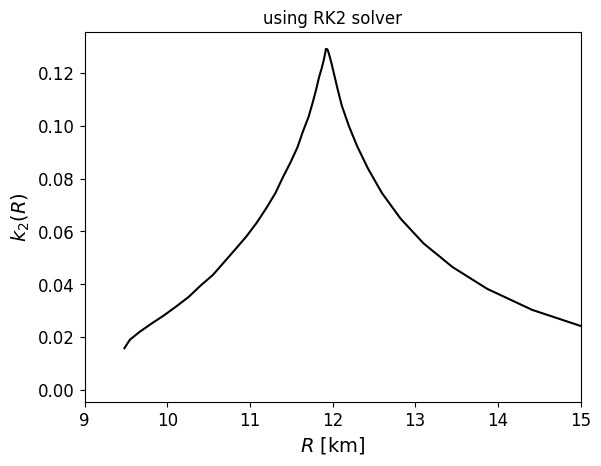

Radius:  10.109720032999997 Maximum mass:  2.0671529454228352 Central pressure:  820.9659111615389
Time: 9.743268966674805 seconds
R of 1.4 solar mass star:  11.791458510710168
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671529454228352 Radius:  10.109720032999997 Central pressure:  820.9659111615389
Max mass array:  [0.12442629 0.13442794 0.14610401 0.15927911 0.17383328 0.19074475
 0.21024412 0.23216249 0.25623283 0.28216254 0.31134561 0.34434591
 0.38081544 0.42026094 0.46205856 0.50726007 0.55744434 0.61189093
 0.66967149 0.72969801 0.79196073 0.85908146 0.93005371 1.00335704
 1.07735244 1.15098225 1.22700919 1.30457919 1.38176784 1.45666698
 1.52777148 1.59724067 1.66476511 1.72864363 1.78732498 1.83964473
 1.88709274 1.92994439 1.96729917 1.99840696 2.02282611 2.0415933
 2.05529204 2.06382561 2.06715295 2.06537497 2.05893244 2.04827093
 2.03375753 2.01578969]


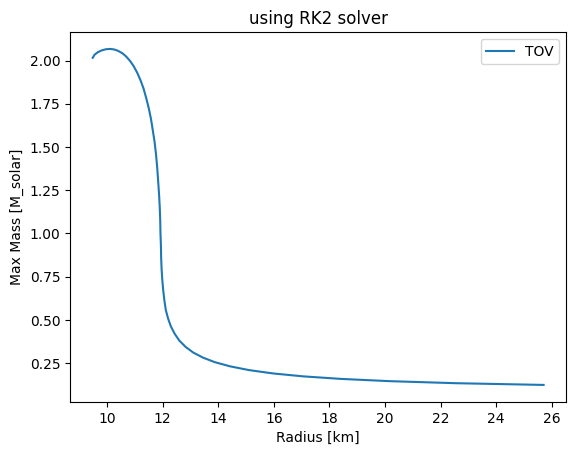

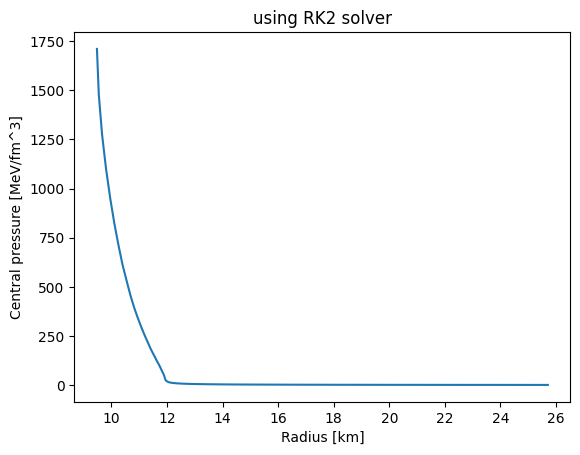

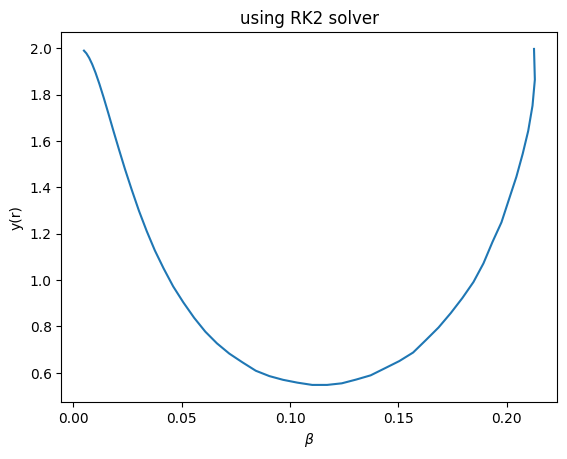

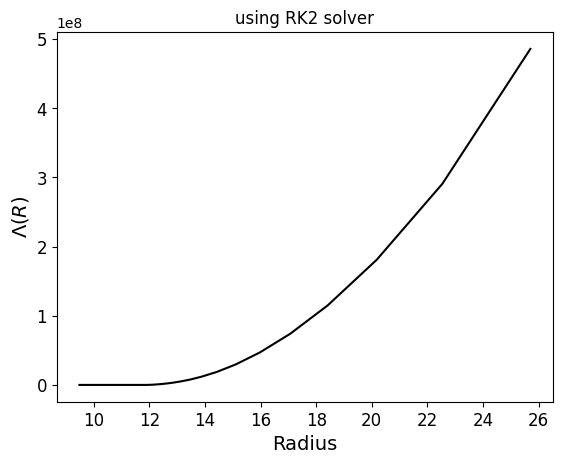

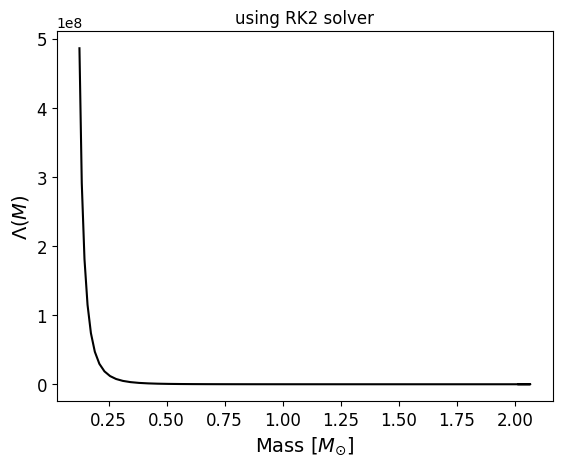

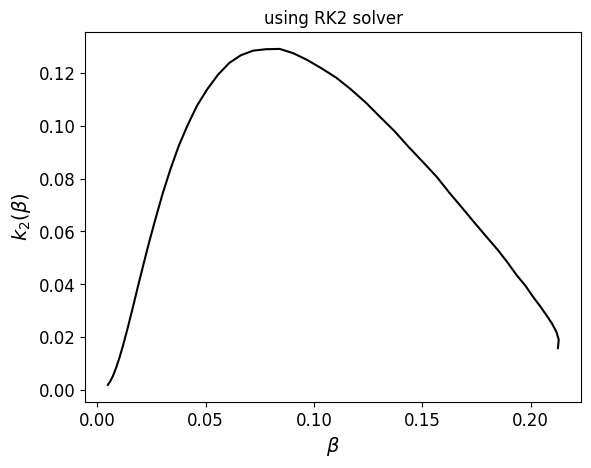

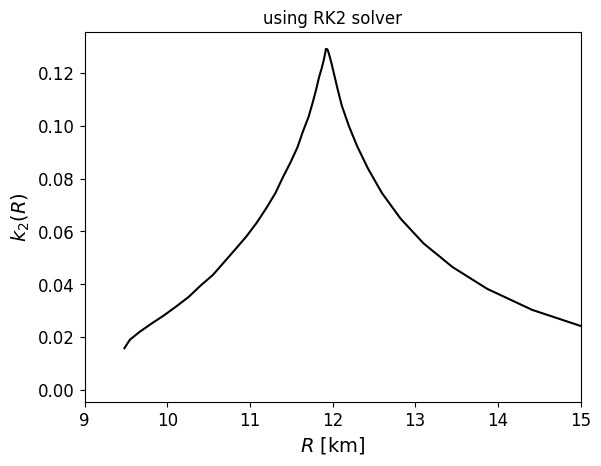

Radius:  10.109720032999997 Maximum mass:  2.0671529454228352 Central pressure:  820.9659111615389
Time: 9.83934497833252 seconds
R of 1.4 solar mass star:  11.791458510710168
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0671529454228352 Radius:  10.109720032999997 Central pressure:  820.9659111615389
Max mass array:  [0.12442629 0.13442794 0.14610401 0.15927911 0.17383328 0.19074475
 0.21024412 0.23216249 0.25623283 0.28216254 0.31134561 0.34434591
 0.38081544 0.42026094 0.46205856 0.50726007 0.55744434 0.61189093
 0.66967149 0.72969801 0.79196073 0.85908146 0.93005371 1.00335704
 1.07735244 1.15098225 1.22700919 1.30457919 1.38176784 1.45666698
 1.52777148 1.59724067 1.66476511 1.72864363 1.78732498 1.83964473
 1.88709274 1.92994439 1.96729917 1.99840696 2.02282611 2.0415933
 2.05529204 2.06382561 2.06715295 2.06537497 2.05893244 2.04827093
 2.03375753 2.01578969]


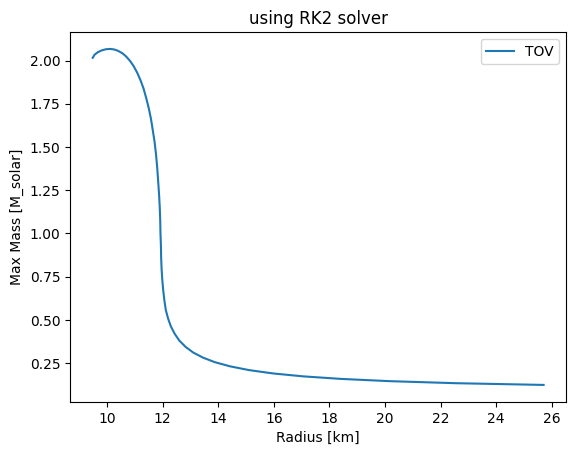

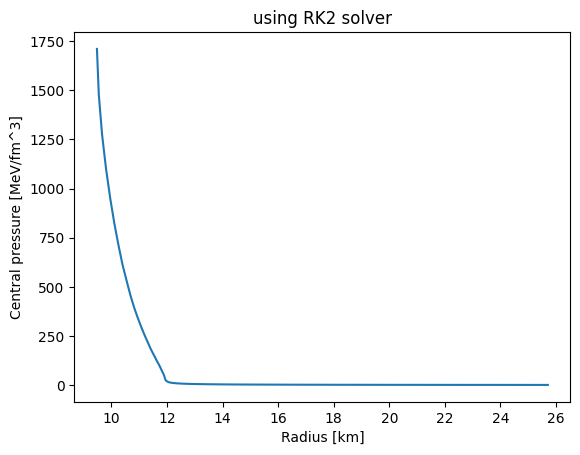

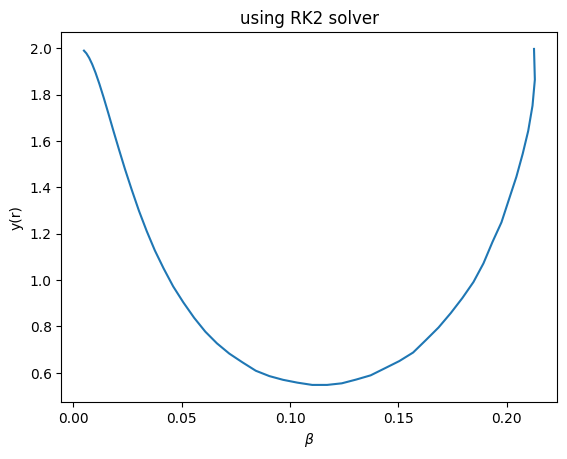

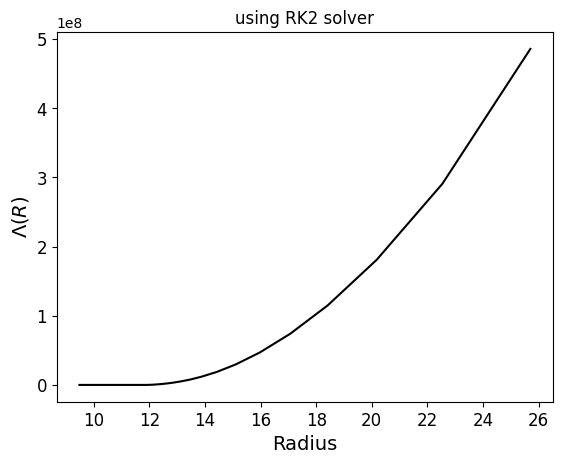

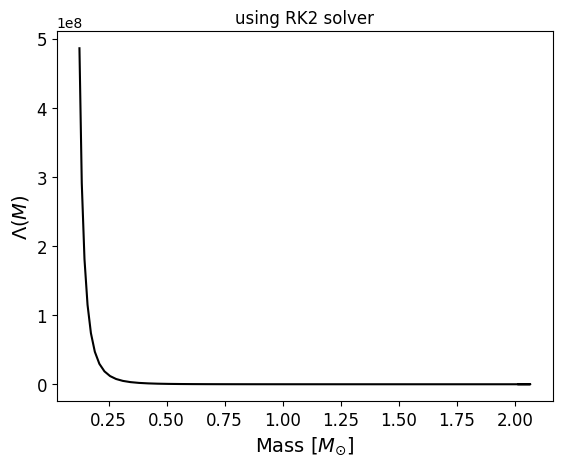

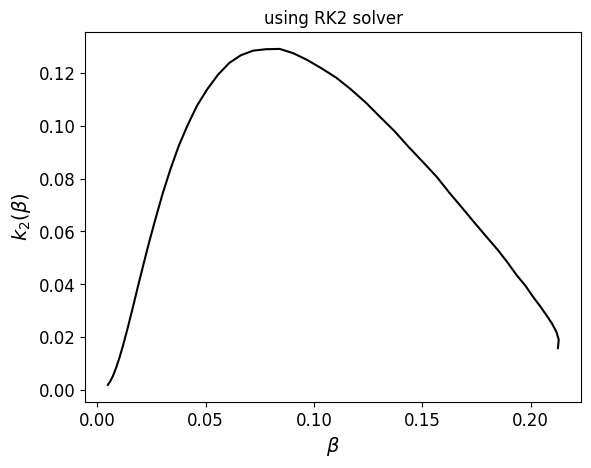

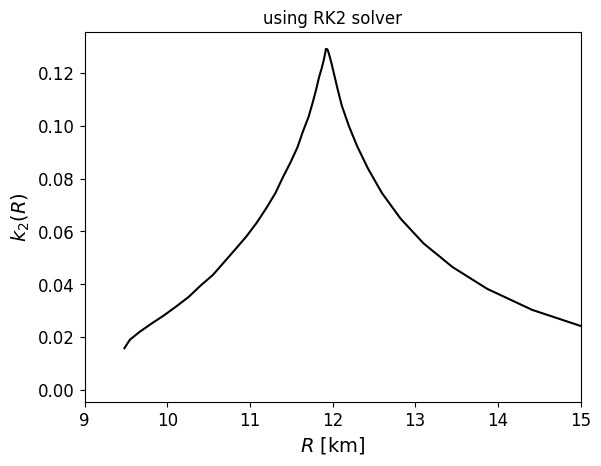

Radius:  10.109720032999997 Maximum mass:  2.0671529454228352 Central pressure:  820.9659111615389
Time: 9.893973112106323 seconds
R of 1.4 solar mass star:  11.791458510710168


In [10]:
# look at RK2 solver
for i in np.arange(number_of_solves):
    tov_rk2 = TOVsolver(fileName, tidal=True, solver="RK2")
    start_time = time.time()
    tov_rk2.tov_routine(verbose=True, write_to_file=False)
    end_time = time.time()
    print("Time: {} seconds".format(end_time - start_time))

    print("R of 1.4 solar mass star: ", tov_rk2.canonical_NS_radius())

In [21]:
print(f"RK2 runtime: {np.mean(rk2_runtimes):.4}s ± {np.std(rk2_runtimes):.4}s")

RK2 runtime: 9.356s ± 0.09464s


/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0665752548992593 Radius:  10.025960977999999 Central pressure:  820.9659111615389
Max mass array:  [0.12457128 0.13462075 0.14634393 0.15956361 0.17416101 0.19112518
 0.21068095 0.2326556  0.25677967 0.2827598  0.31200535 0.34507337
 0.38160972 0.42111732 0.46296904 0.50823338 0.55848743 0.61300048
 0.67083868 0.73090999 0.79321434 0.86038422 0.93139883 1.00473072
 1.07873591 1.15236141 1.22838861 1.30594901 1.38311117 1.45796345
 1.52900139 1.59840553 1.66585521 1.72964427 1.78821919 1.84041643
 1.88774031 1.930463   1.9676799  1.99863928 2.02289979 2.04150837
 2.05504673 2.06341674 2.06657525 2.06462445 2.05800515 2.04716581
 2.03247194 2.01432099]


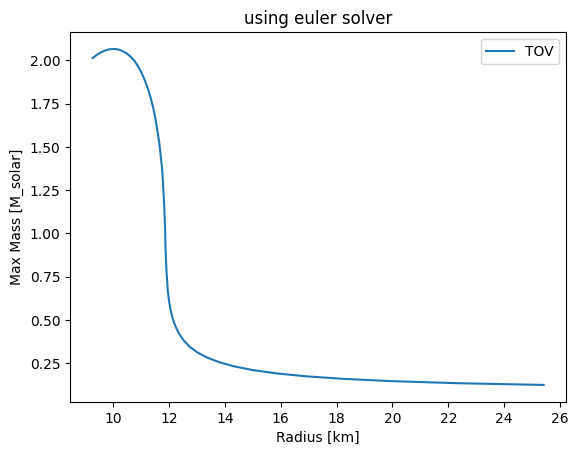

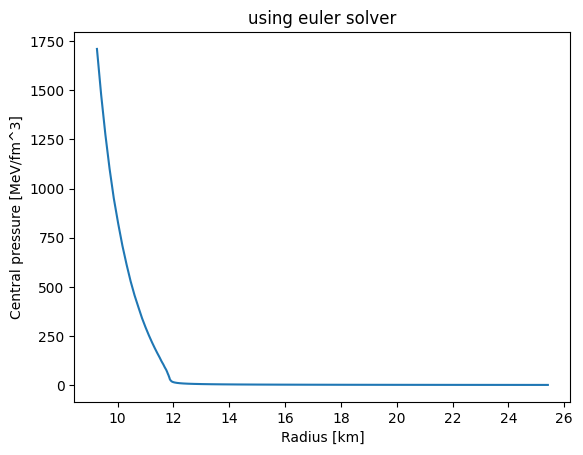

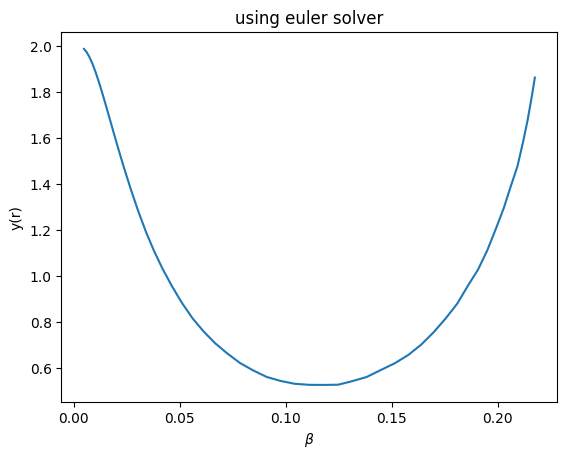

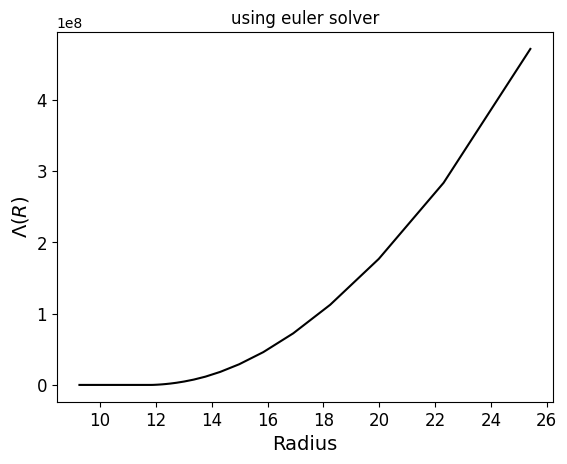

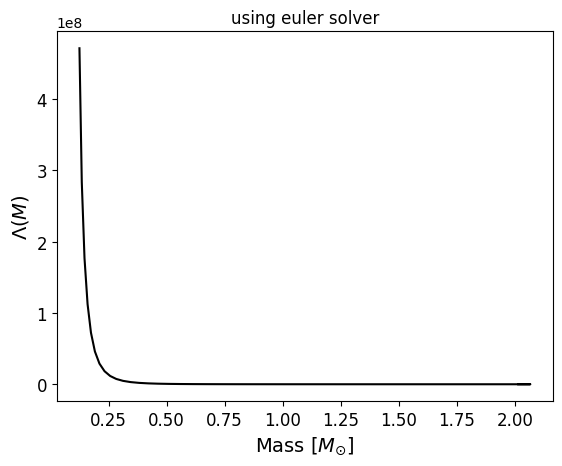

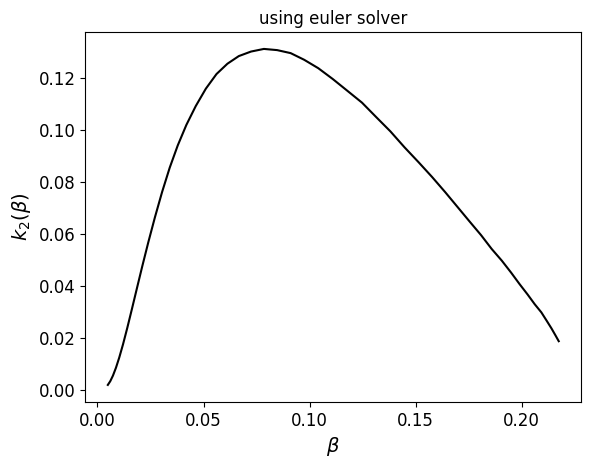

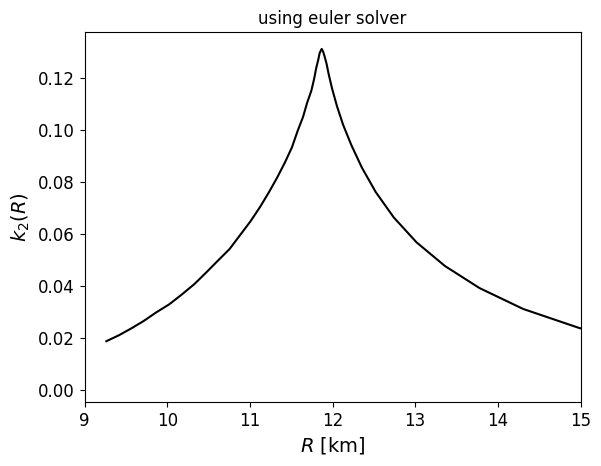

Radius:  10.025960977999999 Maximum mass:  2.0665752548992593 Central pressure:  820.9659111615389
Time: 4.935007095336914 seconds
R of 1.4 solar mass star:  11.731682533405946
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0665752548992593 Radius:  10.025960977999999 Central pressure:  820.9659111615389
Max mass array:  [0.12457128 0.13462075 0.14634393 0.15956361 0.17416101 0.19112518
 0.21068095 0.2326556  0.25677967 0.2827598  0.31200535 0.34507337
 0.38160972 0.42111732 0.46296904 0.50823338 0.55848743 0.61300048
 0.67083868 0.73090999 0.79321434 0.86038422 0.93139883 1.00473072
 1.07873591 1.15236141 1.22838861 1.30594901 1.38311117 1.45796345
 1.52900139 1.59840553 1.66585521 1.72964427 1.78821919 1.84041643
 1.88774031 1.930463   1.9676799  1.99863928 2.02289979 2.04150837
 2.05504673 2.06341674 2.06657525 2.06462445 2.05800515 2.04716581
 2.03247194 2.01432099]


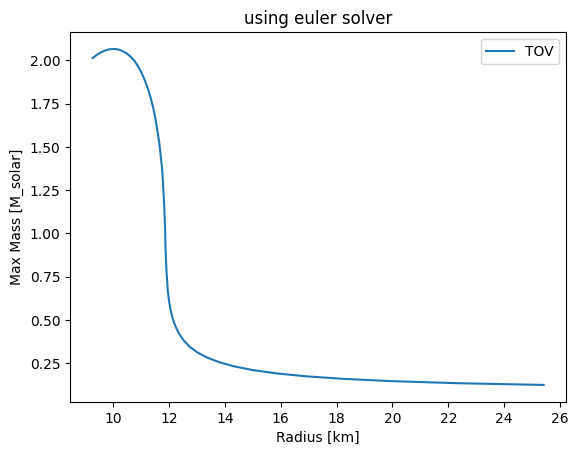

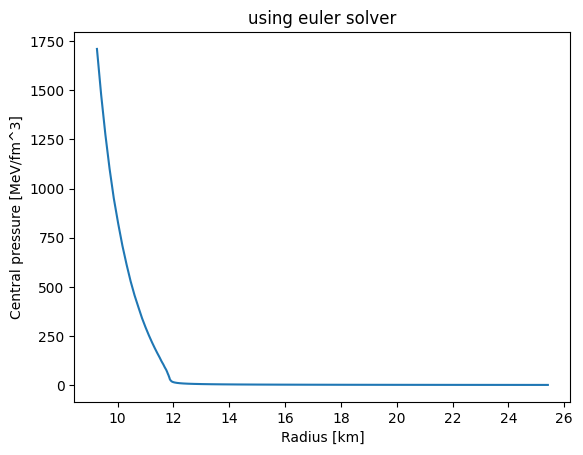

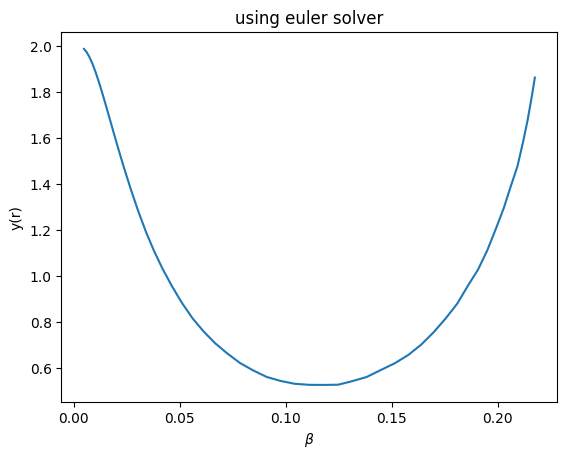

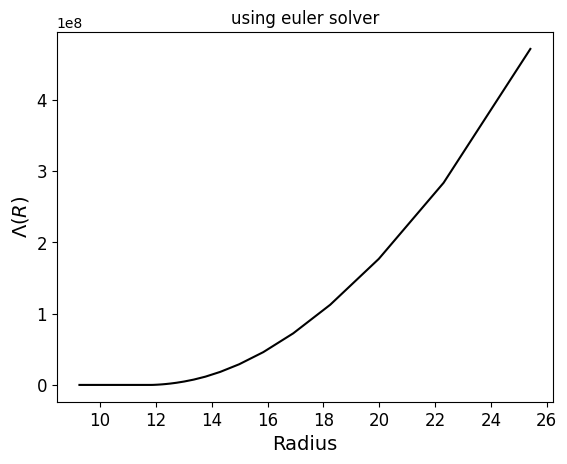

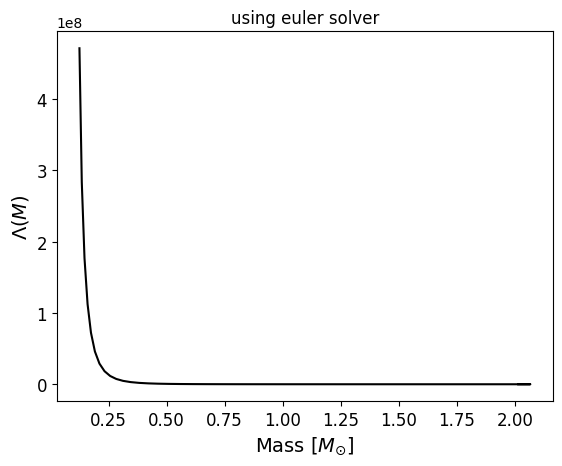

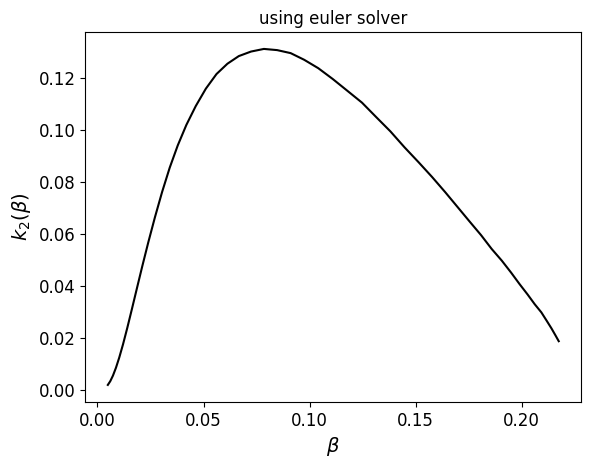

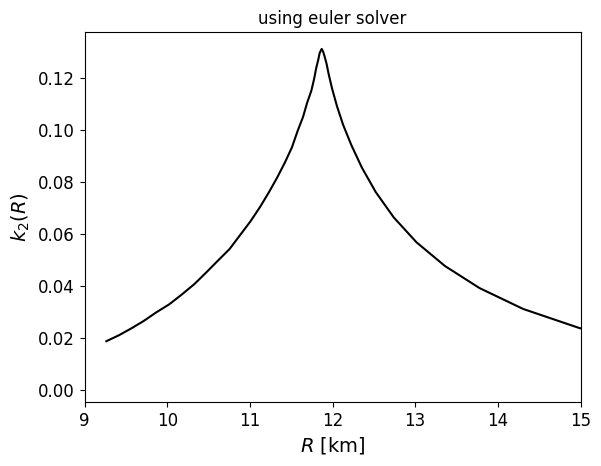

Radius:  10.025960977999999 Maximum mass:  2.0665752548992593 Central pressure:  820.9659111615389
Time: 4.878932952880859 seconds
R of 1.4 solar mass star:  11.731682533405946
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0665752548992593 Radius:  10.025960977999999 Central pressure:  820.9659111615389
Max mass array:  [0.12457128 0.13462075 0.14634393 0.15956361 0.17416101 0.19112518
 0.21068095 0.2326556  0.25677967 0.2827598  0.31200535 0.34507337
 0.38160972 0.42111732 0.46296904 0.50823338 0.55848743 0.61300048
 0.67083868 0.73090999 0.79321434 0.86038422 0.93139883 1.00473072
 1.07873591 1.15236141 1.22838861 1.30594901 1.38311117 1.45796345
 1.52900139 1.59840553 1.66585521 1.72964427 1.78821919 1.84041643
 1.88774031 1.930463   1.9676799  1.99863928 2.02289979 2.04150837
 2.05504673 2.06341674 2.06657525 2.06462445 2.05800515 2.04716581
 2.03247194 2.01432099]


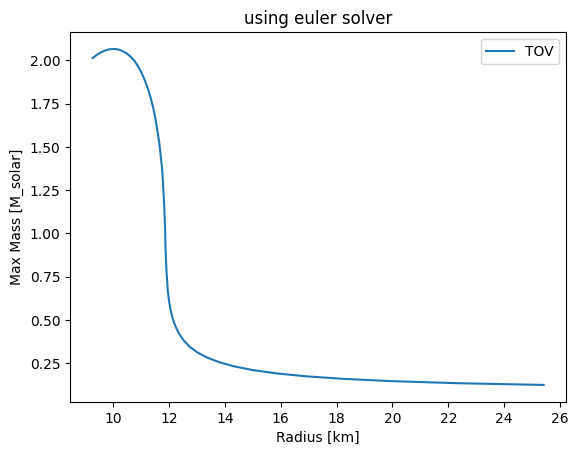

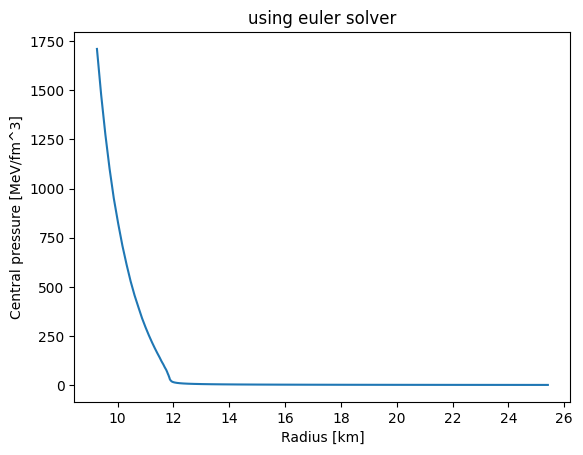

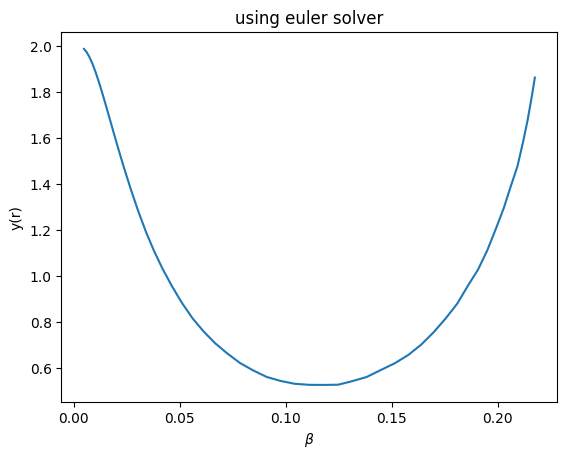

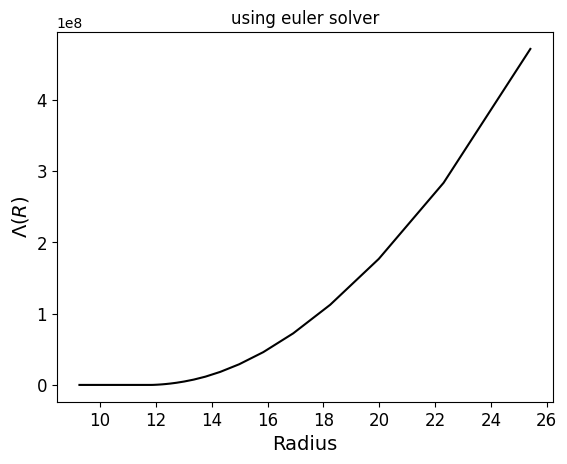

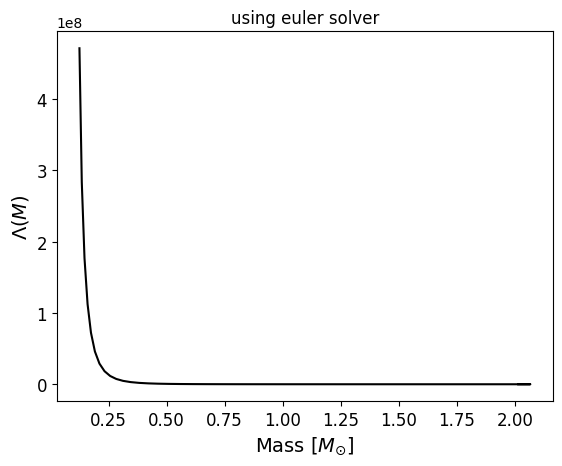

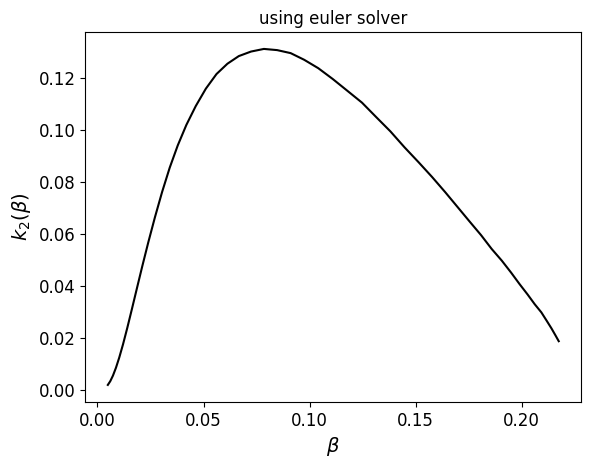

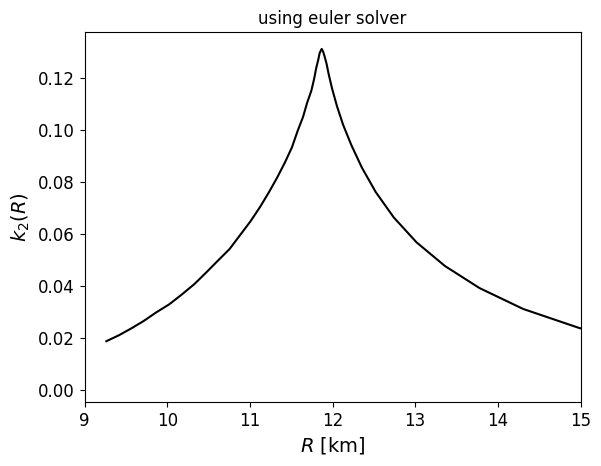

Radius:  10.025960977999999 Maximum mass:  2.0665752548992593 Central pressure:  820.9659111615389
Time: 4.759090185165405 seconds
R of 1.4 solar mass star:  11.731682533405946
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0665752548992593 Radius:  10.025960977999999 Central pressure:  820.9659111615389
Max mass array:  [0.12457128 0.13462075 0.14634393 0.15956361 0.17416101 0.19112518
 0.21068095 0.2326556  0.25677967 0.2827598  0.31200535 0.34507337
 0.38160972 0.42111732 0.46296904 0.50823338 0.55848743 0.61300048
 0.67083868 0.73090999 0.79321434 0.86038422 0.93139883 1.00473072
 1.07873591 1.15236141 1.22838861 1.30594901 1.38311117 1.45796345
 1.52900139 1.59840553 1.66585521 1.72964427 1.78821919 1.84041643
 1.88774031 1.930463   1.9676799  1.99863928 2.02289979 2.04150837
 2.05504673 2.06341674 2.06657525 2.06462445 2.05800515 2.04716581
 2.03247194 2.01432099]


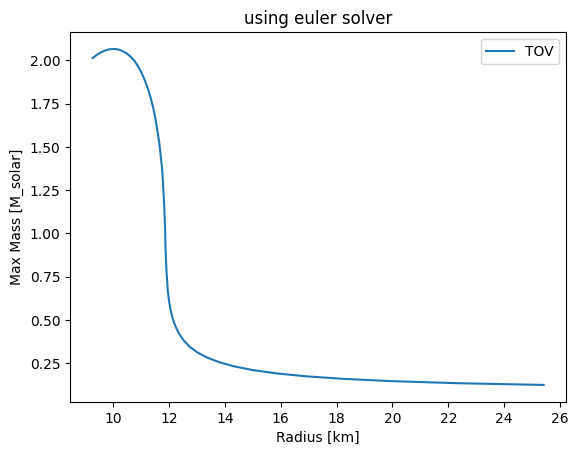

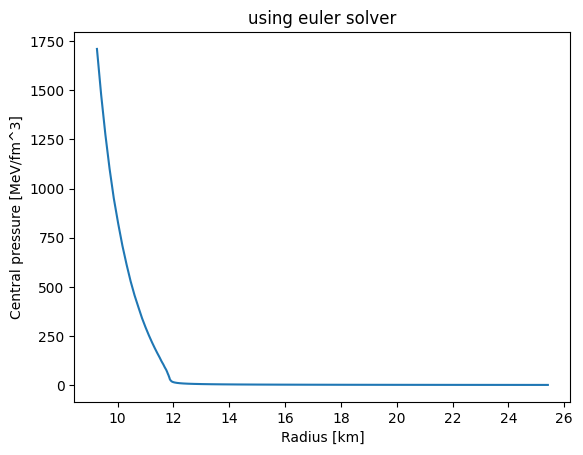

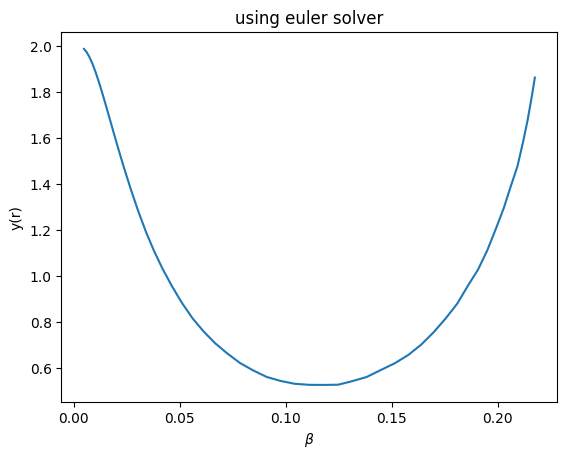

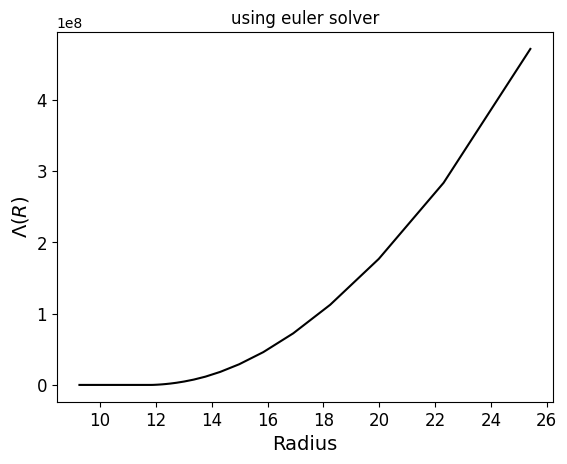

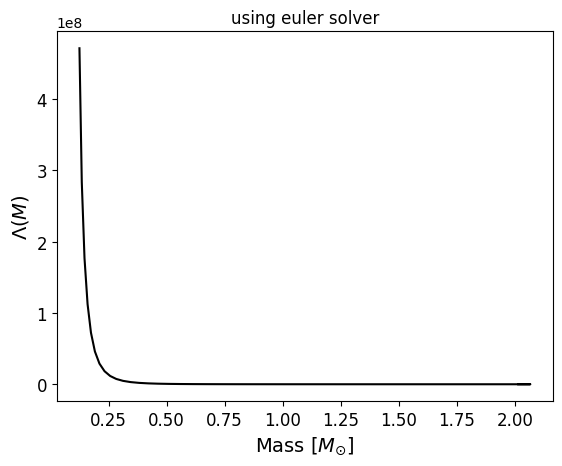

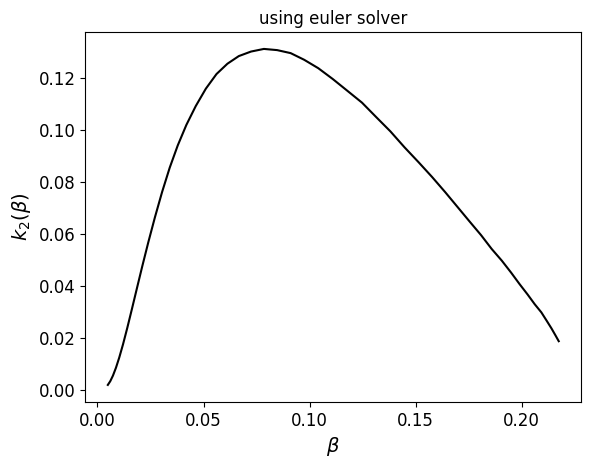

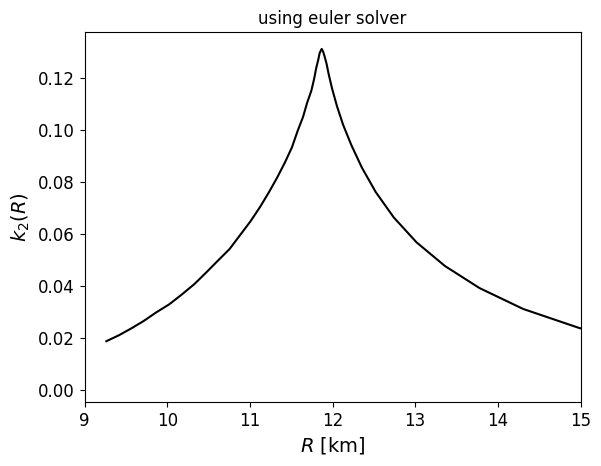

Radius:  10.025960977999999 Maximum mass:  2.0665752548992593 Central pressure:  820.9659111615389
Time: 4.826425790786743 seconds
R of 1.4 solar mass star:  11.731682533405946
/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/sorted_Sly4
Woo it worked!
Max mass:  2.0665752548992593 Radius:  10.025960977999999 Central pressure:  820.9659111615389
Max mass array:  [0.12457128 0.13462075 0.14634393 0.15956361 0.17416101 0.19112518
 0.21068095 0.2326556  0.25677967 0.2827598  0.31200535 0.34507337
 0.38160972 0.42111732 0.46296904 0.50823338 0.55848743 0.61300048
 0.67083868 0.73090999 0.79321434 0.86038422 0.93139883 1.00473072
 1.07873591 1.15236141 1.22838861 1.30594901 1.38311117 1.45796345
 1.52900139 1.59840553 1.66585521 1.72964427 1.78821919 1.84041643
 1.88774031 1.930463   1.9676799  1.99863928 2.02289979 2.04150837
 2.05504673 2.06341674 2.06657525 2.06462445 2.05800515 2.04716581
 2.03247194 2.01432099]


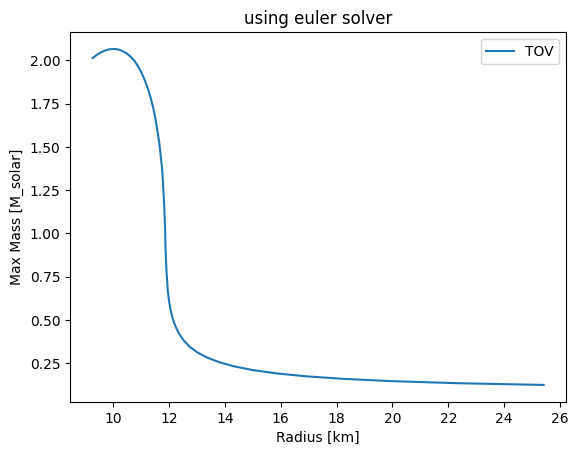

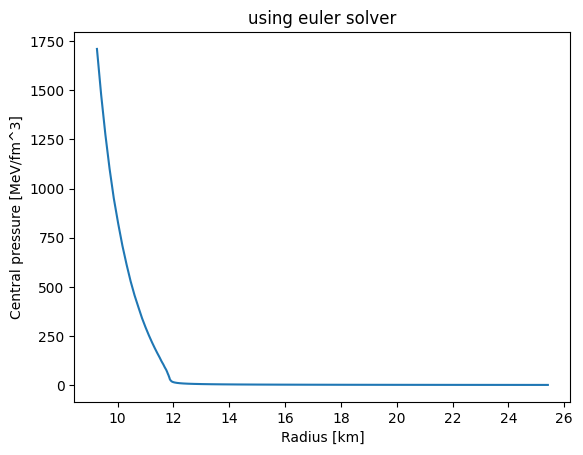

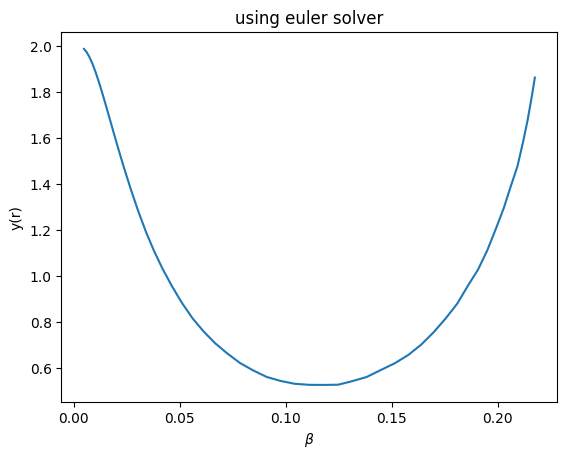

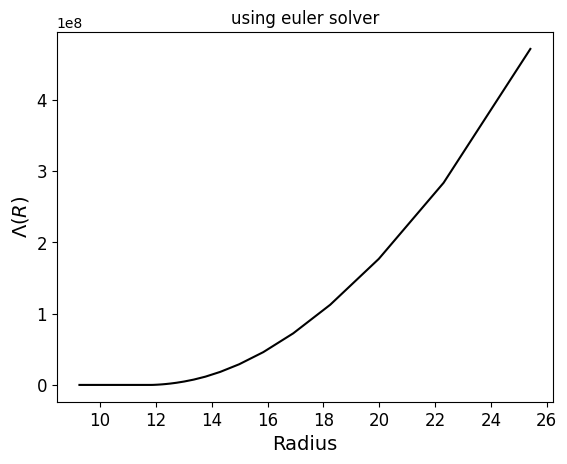

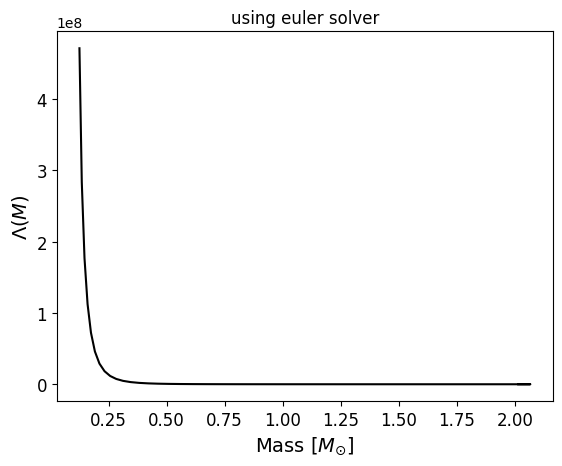

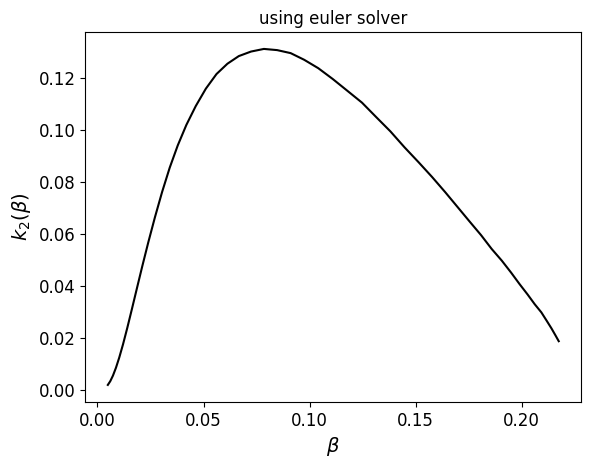

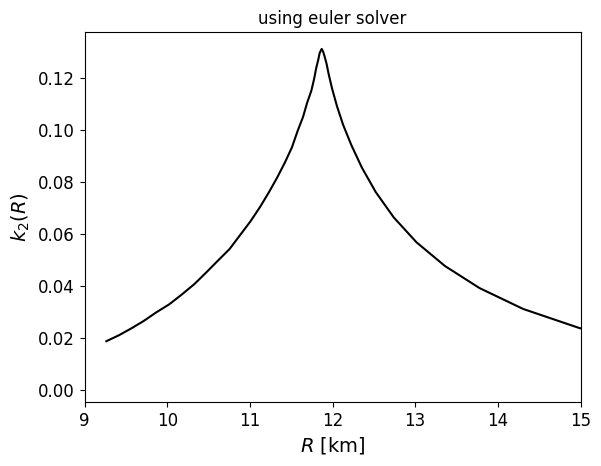

Radius:  10.025960977999999 Maximum mass:  2.0665752548992593 Central pressure:  820.9659111615389
Time: 4.8083789348602295 seconds
R of 1.4 solar mass star:  11.731682533405946


In [12]:
# look at forward-euler solver
for i in np.arange(number_of_solves):
    tov_euler = TOVsolver(fileName, tidal=True, solver="euler")
    start_time = time.time()
    tov_euler.tov_routine(verbose=True, write_to_file=False)
    end_time = time.time()
    print("Time: {} seconds".format(end_time - start_time))

    print("R of 1.4 solar mass star: ", tov_euler.canonical_NS_radius())

In [13]:
print(f"euler runtime: {np.mean(euler_runtimes):.4}s ± {np.std(euler_runtimes):.4}s")

euler runtime: 4.442s ± 0.06105s


In [22]:
print("Solver Runtimes:")
try:
    print(f"solve_ivp runtime (atol=rtol=1e-8, method=\"Radau\"): {np.mean(solve_ivp_runtimes):.4}s ± {np.std(solve_ivp_runtimes):.4}s")
except:
    pass
print(f"RK4 runtime: {np.mean(rk4_runtimes):.4}s ± {np.std(rk4_runtimes):.4}s")
print(f"RK2 runtime: {np.mean(rk2_runtimes):.4}s ± {np.std(rk2_runtimes):.4}s")
print(f"euler runtime: {np.mean(euler_runtimes):.4}s ± {np.std(euler_runtimes):.4}s")

Solver Runtimes:
solve_ivp runtime (atol=rtol=1e-8, method="Radau"): 55.37s ± 0.8872s
RK4 runtime: 17.73s ± 0.157s
RK2 runtime: 9.356s ± 0.09464s
euler runtime: 4.442s ± 0.06105s
